In [1]:
#Import required packages
import inspect
import numpy as np
import pandas as pd
import random, os
import time
import datetime as dt
from datetime import datetime, timedelta
import lightgbm as lgb
%matplotlib inline
pd.set_option('max_rows',500)
pd.set_option('max_columns',500)
import warnings
warnings.filterwarnings('ignore')
import calendar
from pathlib import Path
import math
import copy
from sklearn import preprocessing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import yfinance as yf
import pandas as pd
import sqlalchemy
import datetime as dt
from pandas.tseries.offsets import MonthEnd

from func_util_stock_market_forecasting import *
from univariate_modeling import *

seed_everything(42)

In [2]:
#Input paths 
root_path = Path(os.getcwd())
input_path = root_path / "Inputs"
output_path = root_path / "Outputs"
google_mob_path = input_path / "Google Mobility Data"

if not os.path.isdir(output_path):
    os.mkdir(output_path) 

train_forecasts_output_filename = "train_forecasts_method"
forecast_all_output_filename = "forecast_all_output_method"  
google_mob_filename = 'Global_Mobility_Report.csv'
select_country = 'India'

#Changing the latest Date as per requirement 
min_date = '2018-01-01' #(NO NEED TO CHANGE)
max_date = '2022-06-06' 

#Forecast duration
forecast_weeks = 5 #(format dtype: int)
forecast_weeks = int(forecast_weeks)  

In [3]:
wiki = 'https://en.wikipedia.org/wiki/'
tickersSensex = pd.read_html(wiki+'BSE_SENSEX')[1].Symbol.to_list()

data = []

for ticker in tickersSensex:
    data.append(yf.download(ticker).reset_index())

if os.path.exists("India.db"):
    os.remove("India.db")
else:
    print("The db need to be created")    

engine = sqlalchemy.create_engine('sqlite:///India.db')

for frame, symbol in zip(data, tickersSensex):
    frame.to_sql(symbol, engine, index=False)

df = pd.DataFrame(columns={'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'})
for i in range(len(tickersSensex)):
    sql_text = 'SELECT * FROM "'+tickersSensex[i]+'"'
    df_iter = pd.read_sql(sql_text, engine)
    df_iter['Date'] = pd.to_datetime(df_iter['Date'])
    df_iter['Stock'] = tickersSensex[i][:-3] 
    df = df.append(df_iter)
del df_iter

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
df_daily_contribution = daily_percentage(df[['Date','Open']])

In [5]:
df = data_wrangling_df(df, max_date, min_date)


Latest Date : 2022-06-22 00:00:00

Last date after the change as per requirement : 2018-01-01 00:00:00

Latest date after the change as per requirement : 2022-06-06 00:00:00


In [6]:
#Getting current week and last 5 weeks
current_week, last_5_week = day_contribution(df)

#Getting future 5 weeks (+ 4 weeks of multiple iteration)
df, new_last_5_week = last_week_shift(df,current_week)

#Function to get the Week Number of each month
df = get_week_of_month_df(df, get_week_of_month)

##Feature to capture the peak stock across week of the month
df = peak_week_of_month(df)
#Brewery-SKU combination pairs
df['pair_comb']= df['Stock'].astype(str)
stock_list = df.pair_comb.unique()

#Copying the dates df
df_dates = df[['Date']].copy()

#Copying all the date features into a dataframe
df_date_features = df[['Date','pair_comb','week', 'year', 'month','week_all', 'month_all', 'Week_of_month', 'peak_week_flag']].reset_index(drop=True).copy()
df_copy = df.copy()


Current week is: 232 (i.e. 2022-06-06 00:00:00)

Last 5 weeks are: [228, 229, 230, 231, 232] (i.e. from 2022-05-09 00:00:00 to 2022-06-06 00:00:00)

5 weeks to be forecasted in the final iteration are: [237, 238, 239, 240, 241] (i.e. from 2022-07-11 00:00:00 to 2022-08-08 00:00:00)


In [7]:
#Copying the dates df
df_dates = df[['Date']].copy()
data1_in = get_forecast_dates_df(df_dates)

##Parameters for iterations
train_decrease_window = 1
N_RUNS = 5
first_forecast_week_index = new_last_5_week[-1] #Last index of 5 weeks to be forecasted in the final iteration
train_val_params_list = get_train_val_params(data1_in,last_forecast_week_index=first_forecast_week_index-5,N_RUNS=N_RUNS,train_decrease_window = train_decrease_window)

#Setting error weights for training and validation
error_weights = {'train_error_weight': 0.3,
                 'val_error_weight':0.7}

#Setting up model hyperparameters
model_params = {'rf':{'max_depth':5,'n_estimators':120,'random_state':0},
                'xgb':{'max_depth':4,'n_estimators':30,'random_state':0},
                'lgbm' :{"objective" : "regression","metric" : "rmse","num_leaves" : 60,"learning_rate" : 0.004,
                     "bagging_fraction" : 0.6,"feature_fraction" : 0.6,"bagging_frequency" : 6,"bagging_seed" : 42,
                     "verbosity" : -1,"seed": 42},
                'gbm' : {'n_estimators': 100,'max_depth': 6,'min_samples_split': 8,'learning_rate': 0.01,'loss': 'ls'},
                'ada' : {'n_estimators': 150,'learning_rate': 0.01,'loss': 'linear'},
                'et' : {'n_estimators': 150,'max_depth': 6,'min_samples_split': 8,'criterion': 'mse'},
                'hist' : {'max_depth': 8,'max_leaf_nodes': 50,'learning_rate': 0.01,'loss': 'least_squares'},
                'cb' : {"num_leaves" : 60, 'loss_function' : 'MAPE', 'learning_rate': 0.01, 'n_estimators' : 20, 'verbose' : False}
               }

In [8]:
train_val_params_list_copy = train_val_params_list.copy()
[train_val_params_list[-1]]

[{'train_start': Timestamp('2018-01-01 00:00:00'),
  'train_end': Timestamp('2022-05-02 00:00:00'),
  'val_start': Timestamp('2022-05-09 00:00:00'),
  'val_end': Timestamp('2022-06-06 00:00:00'),
  'test_start': Timestamp('2022-06-13 00:00:00'),
  'test_end': Timestamp('2022-07-11 00:00:00')}]

In [9]:
# #Checking forecast accuracies
# output_path = root_path / "Outputs 2022-01-23"

# df = df[['Date','Returns','Sales','pair_comb']]

# forecast_df = pd.read_excel(output_path/'final_forecast_ensemble_latest.xlsx')
# forecast_df_daily = pd.read_excel(output_path / '5_weeks_final_forecast_ensemble_latest_daily.xlsx')

# df = df[df['Date'].isin([pd.to_datetime('2022-01-24')])]
# df_check = df.merge(forecast_df.rename(columns={'date':'Date'}),on=['Date','pair_comb'],how='left')

# forecast_df_daily = forecast_df_daily.groupby(['pair_comb','week'])['Final_forecast'].sum().reset_index().rename(columns={'Final_forecast':'Final_forecast_daily'})
# forecast_df_daily = forecast_df_daily[forecast_df_daily['week']==4]

# df_check = df_check.merge(forecast_df_daily,on='pair_comb',how='left')
# df_check.to_excel(output_path / 'df_check.xlsx')

In [10]:
# #GAC forecast
# forecast_df = pd.DataFrame()
# for file in os.listdir("C:/Users/40102982/OneDrive - Anheuser-Busch InBev/Empties Planning Mexico Weekly Forecast runs/5 weeks forecasts/all/"):
#     if '~$' not in file:
#         print(file)
#         forecast_df_ = pd.ExcelFile("C:/Users/40102982/OneDrive - Anheuser-Busch InBev/Empties Planning Mexico Weekly Forecast runs/5 weeks forecasts/all/"+file)
#         forecast_df_ = pd.read_excel(forecast_df_)
#         forecast_df_['forecast_date'] = pd.to_datetime(file[-15:-5])
#         forecast_df_ = forecast_df_[['pair_comb', 'date','year','week','Final_forecast','forecast_date']]
#         forecast_df = forecast_df.append(forecast_df_)        
# forecast_df = forecast_df.sort_values(by=['forecast_date'],ascending=False)
# forecast_df = forecast_df.drop_duplicates(subset=['pair_comb','date'],keep='first')
# forecast_df = forecast_df.groupby(['pair_comb','year','week'])[['Final_forecast']].sum().reset_index()

# #RTI
# RTI_1 = pd.read_excel(rti_path/'Comparativo Julio a Oct 2021.xlsx',sheet_name='entradas_planta_contra_real_jul')
# RTI_2 = pd.read_csv(rti_path/'comparison_11_2021 nov completo.csv')
# RTI_3 = pd.read_csv(rti_path/'comparison_12_2021.csv')
# RTI_4 = pd.read_excel(rti_path/'Comparativo Ene_2022.xlsx',sheet_name='comparison_1_2022')
# RTI_5 = pd.read_excel(rti_path/'comparison_Feb_2022.xlsx',sheet_name='comparison_2_2022')
# RTI_6 = pd.read_excel(rti_path/'comparison_Mzo_2022.xlsx',sheet_name='comparison_3_2022 (1)')
# RTI_1 = RTI_1[['planta', 'sku', 'fecha', 'entradas_planta', 'ensamble', 'benchmark']]
# RTI_1['fecha'] = pd.to_datetime(RTI_1['fecha'], errors='coerce', format='%d-%m-%Y')
# RTI_2 = RTI_2[['planta', 'sku', 'fecha', 'entradas_planta', 'ensamble', 'benchmark']]
# RTI_2['fecha'] = pd.to_datetime(RTI_2['fecha'], errors='coerce', format='%d-%m-%Y')
# RTI_3 = RTI_3[['planta', 'sku', 'fecha', 'entradas_planta', 'ensamble', 'benchmark']]
# RTI_3['fecha'] = pd.to_datetime(RTI_3['fecha'])
# RTI_4 = RTI_4[['planta', 'sku', 'fecha', 'entradas_planta', 'ensamble', 'benchmark']]
# RTI_4['fecha'] = pd.to_datetime(RTI_4['fecha'], errors='coerce', format='%d-%m-%Y')
# RTI_5 = RTI_5[['planta', 'sku', 'fecha', 'entradas_planta', 'ensamble', 'benchmark']]
# RTI_5['fecha'] = pd.to_datetime(RTI_5['fecha'], errors='coerce', format='%d-%m-%Y')
# RTI_6 = RTI_6[['planta', 'sku', 'fecha', 'entradas_planta', 'ensamble', 'benchmark']]
# RTI_6['fecha'] = pd.to_datetime(RTI_6['fecha'], errors='coerce', format='%d-%m-%Y')
# RTI = pd.concat([RTI_1,RTI_2],axis=0)
# RTI = pd.concat([RTI,RTI_3],axis=0)
# RTI = pd.concat([RTI,RTI_4],axis=0)
# RTI = pd.concat([RTI,RTI_5],axis=0)
# RTI = pd.concat([RTI,RTI_6],axis=0)
# del RTI_1, RTI_2, RTI_3, RTI_4, RTI_5, RTI_6
# RTI = data_wrangling_rti(RTI, catalogue, mapping)
# RTI['pair_comb'] = RTI['Plant'].astype(str)+'_'+RTI['Returnable Group'].astype(str)

# #Actuals
# df['pair_comb'] = df['Plant'].astype(str)+'_'+df['Returnable Group'].astype(str)
# df['week'] = df['Date'].dt.week
# df['year'] = df['Date'].dt.year
# df = df[['pair_comb','week','year','Returns']]

# #Merged file
# forecast_df = forecast_df.merge(RTI[['pair_comb','year','week','Weekly_RTI_forecast']],on=['pair_comb','year','week'],how='left')
# forecast_df['null_flag_rti'] = np.where(forecast_df['Weekly_RTI_forecast'].isna(),1,0)
# forecast_df = forecast_df.merge(df,on=['pair_comb','year','week'],how='left').fillna(0)
# forecast_df['null_flag'] = np.where(forecast_df['Returns']==0,1,0)
# forecast_df.to_excel("C:/Users/40102982/OneDrive - Anheuser-Busch InBev/Empties Planning Mexico Weekly Forecast runs/5 weeks forecasts/all/"+'forecast_df.xlsx',index=False)

In [11]:
# #Checking forecast accuracies
# output_path = root_path / "Outputs 2022-01-23"

# df = df[['Date','Returns','Sales','pair_comb']]
# df = df[df['Date'].isin([pd.to_datetime('2022-01-24')])]

# forecast_df_daily = pd.read_excel(output_path / '5_weeks_final_forecast_ensemble_latest_daily.xlsx')
# forecast_df_daily = forecast_df_daily.groupby(['pair_comb','week'])['Final_forecast'].sum().reset_index().rename(columns={'Final_forecast':'Final_forecast_daily'})
# forecast_df_daily = forecast_df_daily[forecast_df_daily['week']==4]

# df_check = df.merge(forecast_df_daily,on='pair_comb',how='left')
# df_check.to_excel(output_path / 'df_check.xlsx')

In [12]:
# #Checking forecast accuracies
# output_path = root_path / "Inputs"

# df = df[['Date','Returns','Sales','pair_comb']]
# df = df[df['Date'].isin([pd.to_datetime('2022-01-31')])]

# forecast_df_daily = pd.read_excel(output_path / '5_weeks_final_forecast_ensemble_latest_daily.xlsx')
# forecast_df_daily = forecast_df_daily.groupby(['pair_comb','week'])['Final_forecast'].sum().reset_index().rename(columns={'Final_forecast':'Final_forecast_daily'})
# forecast_df_daily = forecast_df_daily[forecast_df_daily['week']==5]

# df_check = df.merge(forecast_df_daily,on='pair_comb',how='left')
# df_check.to_excel(output_path / 'df_check_v2.xlsx')

In [13]:
# df = pd.read_csv(input_path/"returns_consolidated_DC_LEVEL.csv")

# df_check = pd.read_excel(input_path/"History Integraciones 2021.xlsx", sheet_name="History Int", skiprows=2)

# df_check=df_check[['Año', 'Sap', 'Integrada', 'SAP', 'Receptora', 'Fecha de Integración',
#        'Tipo', 'DRV']]

# df_check['Sap'].isin(df['Ce.']).value_counts()

In [14]:
#OTHERS data
#Getting it in right format
mob_dates_df=df[['Date','week','year','month']].drop_duplicates().reset_index(drop=True).rename(columns={'Date':'date'})
#Getting the forecast dates as array
arr_dates = np.array(list(mob_dates_df['date']))

#Reading in Google mobility data 
others_df = get_mob_features(google_mob_path,google_mob_filename,select_country,mob_dates_df)

#Forecasting data which is unavailable using univate models
measures = {col:np.mean for col in others_df.columns if 'baseline' in col}
mask = (others_df["date"] <= "2021-01-01")
others_df.loc[mask,list(measures.keys())] = others_df.loc[mask,list(measures.keys())].fillna(100)
others_df = others_df[others_df['date']<=pd.to_datetime(max_date)]
others_df = df[['Date']].drop_duplicates().reset_index(drop=True).rename(columns={'Date':'date'}).merge(others_df,on='date',how='left')

for feat in list(others_df.columns[others_df.isnull().any()]):
    forecast_duration = others_df[feat].isnull().sum() 
    data_prophet = others_df[['date',feat]].copy()
    data_prophet = data_prophet.rename({'date': 'ds', feat: 'y'}, axis='columns')[:-forecast_duration]
    model = Prophet().add_country_holidays(country_name='India')
    model.fit(data_prophet)
    future = df[['Date']].drop_duplicates().reset_index(drop=True).rename(columns={'Date':'ds'})
    forecast = model.predict(future)
    others_df[feat][-forecast_duration:] = forecast['yhat'][-forecast_duration:]

gm_list = ['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline','residential_percent_change_from_baseline','workplaces_percent_change_from_baseline']    
for cols in gm_list:
    others_df.loc[others_df[cols]>100.0, cols]=100.0
del mob_dates_df

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='date'>

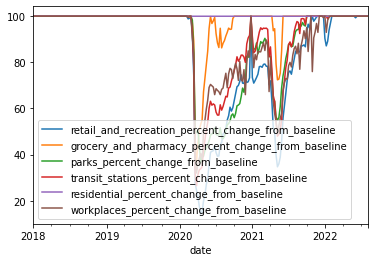

In [15]:
others_df.set_index('date').plot()

In [16]:
#Creating a dataframe in the format of input to model
data1_in = get_forecast_dates_df(df_dates)

for pairs in stock_list:
    data1_in = pd.merge(data1_in,df[df['pair_comb']==pairs][['Open','Date']].rename(columns={'Open':pairs}).set_index('Date'),
                        left_index=True, 
                        right_index=True,
                        how='left')
data1_in = data1_in.reset_index().rename(columns={'index':'date'})

dates_df = get_forecast_dates_df(df_dates).reset_index().rename(columns= {'index':'date'})
#To interpolate the missing values
for pairs in stock_list:
    data1_in_iter = data1_in.loc[data1_in.index<current_week,:][[pairs,'date']].copy()
    data1_in_iter = data1_in_iter.interpolate(method ='pad', limit_direction ='forward', limit = 2)
    dates_df = pd.merge(dates_df,data1_in_iter, on ='date', how='left')
    
data1_in = dates_df.copy()
del data1_in_iter, dates_df

data1_in['year'] = pd.to_datetime(data1_in['date']).dt.year
data1_in['month'] = pd.to_datetime(data1_in['date']).dt.month
data1_in['quarter'] = pd.to_datetime(data1_in['date']).dt.quarter

In [17]:
data1_in.head(5)

,date,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJFINANCE,BHARTIARTL,DRREDDY,HCLTECH,HDFC,HDFCBANK,HINDUNILVR,ICICIBANK,INDUSINDBK,INFY,ITC,KOTAKBANK,LT,M&M,MARUTI,NESTLEIND,NTPC,ONGC,POWERGRID,RELIANCE,SBIN,SUNPHARMA,TCS,TECHM,TITAN,ULTRACEMCO,year,month,quarter
0,2018-01-01,1155.300000,562.550000,3291.36001,5146.450000,1740.500000,482.610791,2399.80000,446.925000,1710.510010,932.109998,1347.760010,312.090002,1645.140015,514.949994,262.300000,1002.590002,1278.480005,755.540002,9579.450000,7876.829980,148.416669,196.160001,201.720001,920.190002,307.600000,575.450012,1327.775000,511.600000,862.700000,4304.219922,2018,1,1
1,2018-01-08,1185.780005,563.400012,3272.71001,5195.879980,1808.369995,476.074634,2458.77998,450.420001,1730.659985,932.855005,1361.200000,312.390002,1721.800000,524.690002,268.289996,1007.270007,1328.220020,761.279993,9419.800000,7861.290039,146.700000,198.569998,200.700000,936.379993,304.690002,590.120020,1373.719995,535.809998,919.419995,4418.290039,2018,1,1
2,2018-01-15,1193.960010,572.940002,3195.15000,4996.519922,1719.780005,459.339502,2457.80000,469.859998,1850.989990,951.725000,1376.529980,335.079999,1679.700000,557.440002,268.179999,1037.000000,1340.470020,760.740002,9382.900000,7779.179980,143.666666,196.850000,197.279999,935.240002,303.460004,580.929980,1421.030005,553.109998,904.390002,4488.379980,2018,1,1
3,2018-01-22,1173.500000,609.774994,3281.62500,5010.700073,1721.500000,445.551155,2509.50000,490.500000,1895.024994,980.550003,1355.274994,354.550003,1698.250000,581.887497,276.712502,1073.650024,1396.087524,761.287506,9387.399902,7630.800049,143.937500,205.212502,196.100002,968.850006,316.612495,577.637497,1543.875000,576.037506,902.450012,4322.862427,2018,1,1
4,2018-01-29,1145.300000,597.629993,3352.77998,4910.220020,1699.880005,403.938220,2305.80000,498.790002,1944.869995,995.700000,1379.830005,350.920001,1746.639990,579.550000,275.579999,1109.800000,1435.749976,769.079993,9519.040039,7453.070020,141.633334,202.739999,194.959998,956.620007,311.179993,578.350000,1560.305005,604.350000,870.080005,4371.039941,2018,1,1


In [18]:
final_features_dict = {}

#Defining the features required
lag_variables_target = [1,2,5,8,12]
rolling_mean = [4,8,12]
trend  = [4,8,12]
#Taking lag 5 weeks for other target features because we won't have the actuals
lag_variables_other_target = [5]

## Pass varaibles to be used in the modelling
target = ['Volume','Adj Close','Low','High','Close']
other_target = ['peak_week_flag'] 


for pairs in stock_list:
    dates_df = get_forecast_dates_df(df_dates).reset_index().rename(columns= {'index':'date'})
    final_features_iter  = dates_df.merge(df[df['pair_comb']==pairs].reset_index(drop=True).drop(columns={'Open','Stock','pair_comb'}).rename(columns={'Date':'date'}),on='date',how='left')
    
    ####--------------------------------------####
    
    #To interpolate the missing values
    for feat in set(final_features_iter.columns)-set(['date']):
        final_features_iter_interpolate = final_features_iter.loc[final_features_iter.date<=pd.to_datetime(max_date) - timedelta(days=6),:][[feat,'date']].copy()
        final_features_iter_interpolate = final_features_iter_interpolate.interpolate(method = 'pad', limit_direction ='forward', limit = 2)
        dates_df = pd.merge(dates_df,final_features_iter_interpolate, on ='date', how='left')
        
    final_features_iter = dates_df.copy()
    final_features_iter_new = dates_df.copy()

    #Getting the forecast dates as array
    arr_dates = np.array(list(final_features_iter['date']))
    
    print("----------------------------------------------------------------")
    print("Forecasting done on list of {} variables for the Stocks: {}".format(target,pairs))
    #Forecasting missing values
    for feat in target:
        forecast_duration = forecast_weeks + 4 #(5 weeks + 4 weeks in multiple iteration)
        final_features_iter_copy = final_features_iter.copy()
        final_features_iter_copy = final_features_iter_copy.fillna(0)
        final_features_iter_copy.loc[(final_features_iter_copy['date']>='2020-04-01')&(final_features_iter_copy['date']<='2020-06-07'), feat] = None
        data_prophet = final_features_iter_copy[['date',feat]]
        data_prophet = data_prophet.rename({'date': 'ds', feat: 'y'}, axis='columns')[:-forecast_duration]
        model = Prophet().add_country_holidays(country_name='India')
        model.fit(data_prophet)
        future = df[['Date']].drop_duplicates().reset_index(drop=True).rename(columns={'Date':'ds'})
        forecast = model.predict(future)
        forecast = forecast[['ds','yhat']].rename(columns={'ds':'date','yhat':feat})
        result = pd.concat([data_prophet.set_index('ds')['y'], forecast.set_index('date')[[feat]]], axis=1)
        final_features_iter_new = final_features_iter_new.drop(columns=feat).merge(forecast, on='date',how='left')
    final_features_iter = final_features_iter_new.copy()
    
    final_features = pd.DataFrame()
    for var in target:
        derived_features = create_derived_features(var,final_features_iter,lag_variables_target,rolling_mean,trend)
        final_features = pd.concat([final_features,derived_features], axis=1)
    
    other_final_features = pd.DataFrame()
    for var in other_target:
        other_derived_features = create_derived_features(var,final_features_iter,lag_variables_other_target,rolling_mean = [],trend = [])
        other_final_features = pd.concat([other_final_features,other_derived_features], axis=1)
 
    final_features['date'] = final_features_iter['date']
    other_final_features['date'] = final_features_iter['date']
    final_features_dict[pairs] = pd.merge(final_features,other_final_features.drop(columns=other_target),on='date',how='left')
    final_features_dict[pairs] = pd.merge(final_features_dict[pairs],df_date_features[df_date_features['pair_comb']==pairs].reset_index(drop=True).drop(columns={'pair_comb'}).rename(columns={'Date':'date'}),on='date',how='left')
    final_features_dict[pairs][set(final_features_dict[pairs].columns)].fillna(0,inplace=True)

    del derived_features, final_features_iter, final_features, other_final_features, other_derived_features

  

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: ASIANPAINT


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: AXISBANK


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: BAJAJ-AUTO


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: BAJAJFINSV


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: BAJFINANCE


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: BHARTIARTL


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: DRREDDY


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: HCLTECH


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: HDFC


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: HDFCBANK


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: HINDUNILVR


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: ICICIBANK


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: INDUSINDBK


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: INFY


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: ITC


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: KOTAKBANK


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: LT


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: M&M


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: MARUTI


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: NESTLEIND


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: NTPC


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: ONGC


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: POWERGRID


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: RELIANCE


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: SBIN


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: SUNPHARMA


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: TCS


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: TECHM


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: TITAN


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


----------------------------------------------------------------
Forecasting done on list of ['Volume', 'Adj Close', 'Low', 'High', 'Close'] variables for the Stocks: ULTRACEMCO


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
for cols in ['Volume', 'Adj Close', 'Low', 'High', 'Close']:
    Variables_forecast = get_forecast_dates_df(df_dates).reset_index().rename(columns={'index':'date'})
    for pairs in stock_list:
        Variables_forecast = Variables_forecast.merge(final_features_dict[pairs][['date',cols]], on='date', how='left').rename(columns={cols:pairs})
    file_name = 'Variables_forecast_latest_'+cols+'_forecast_run.xlsx'
    Variables_forecast.to_excel(output_path/file_name,index=False)
    del Variables_forecast


In [20]:
data1_in_copy = data1_in.copy()
data1_in_original = data1_in.copy()

In [21]:
result_dict = {}
for pairs in stock_list:
    print("Process completed for: ",pairs)
    forecast_duration = forecast_weeks + 4 #(5 weeks + 4 weeks in multiple iteration)
    data1_in_copy.loc[(data1_in_copy['date']>='2020-04-01')&(data1_in_copy['date']<='2020-06-07'), pairs] = None
    data_prophet = data1_in_copy[['date',pairs]].copy()
    data_prophet = data_prophet.rename({'date': 'ds', pairs: 'y'}, axis='columns')[:-forecast_duration]
    
    model = Prophet().add_country_holidays(country_name='India')
    model.fit(data_prophet)
    future = df[['Date']].drop_duplicates().reset_index(drop=True).rename(columns={'Date':'ds'})
    forecast = model.predict(future)
    result_dict[pairs] = forecast[['ds','yhat']].rename(columns={'ds':'date','yhat':'fb_forecast_original'})
    
    #####NOTE: Filling outliers with treated values
    data1_in.loc[(data1_in['date']>='2020-04-01')&(data1_in['date']<='2020-06-07'), pairs] = result_dict[pairs].loc[(result_dict[pairs]['date']>='2020-04-01')&(result_dict[pairs]['date']<='2020-06-07'), 'fb_forecast_original']
    data1_in.loc[(data1_in['date']>='2020-04-01')&(data1_in['date']<='2020-06-07'), pairs] = round(data1_in.loc[(data1_in['date']>='2020-04-01')&(data1_in['date']<='2020-06-07'), pairs],0)
    data1_in.loc[(data1_in[pairs]<0), pairs] = data1_in_original.loc[(data1_in[pairs]<0), pairs]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  ASIANPAINT


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  AXISBANK


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  BAJAJ-AUTO


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  BAJAJFINSV


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  BAJFINANCE


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  BHARTIARTL


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  DRREDDY


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  HCLTECH


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  HDFC


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  HDFCBANK


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  HINDUNILVR


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  ICICIBANK


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  INDUSINDBK


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  INFY


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  ITC


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  KOTAKBANK


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  LT


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  M&M


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  MARUTI


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  NESTLEIND


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  NTPC


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  ONGC


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  POWERGRID


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  RELIANCE


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  SBIN


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  SUNPHARMA


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  TCS


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  TECHM


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  TITAN


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Process completed for:  ULTRACEMCO


In [22]:
# results_fb_prophet = pd.DataFrame(columns = {'date','Predicted_fb','pair_comb','fb_forecast_original'})
results_fb_prophet = pd.DataFrame(columns = {'date','pair_comb','fb_forecast_original'})
for pairs in stock_list:
    result_dict[pairs]['pair_comb'] = pairs
    results_fb_prophet = pd.concat([results_fb_prophet,result_dict[pairs]],axis=0)

results_fb_prophet.to_excel(output_path/'results_fb_prophet_diff_timeframe_latest_forecast_run.xlsx',index=False)
results_fb_prophet

,date,fb_forecast_original,pair_comb
0,2018-01-01,1154.886175,ASIANPAINT
1,2018-01-08,1341.290418,ASIANPAINT
2,2018-01-15,1293.902701,ASIANPAINT
3,2018-01-22,1243.651114,ASIANPAINT
4,2018-01-29,1213.366392,ASIANPAINT
...,...,...,...
236,2022-07-11,6579.064716,ULTRACEMCO
237,2022-07-18,6632.697954,ULTRACEMCO
238,2022-07-25,6686.081464,ULTRACEMCO
239,2022-08-01,6699.264865,ULTRACEMCO


In [23]:
# # import sys
# # !{sys.executable} -m pip install pycaret-ts-alpha --user
# # !pip install pycaret-ts-alpha

# # with functional API
# from pycaret.time_series import *
# # with new object-oriented API
# from pycaret.internal.pycaret_experiment import TimeSeriesExperiment

# forecast_duration = forecast_weeks + 4 #(5 weeks + 4 weeks in multiple iteration)

# # df_lgbm = data1_in[:-forecast_duration].drop(columns={'year','month','quarter'}).copy()
# df_theta = data1_in[:-forecast_duration].drop(columns={'year','month','quarter'}).copy()
# df_exp_smooth = data1_in[:-forecast_duration].drop(columns={'year','month','quarter'}).copy()

# # forecast_dates_lgbm = pd.DataFrame(data1_in.date[-forecast_duration:].unique()).rename(columns={0:'date'})
# forecast_dates_theta = pd.DataFrame(data1_in.date[-forecast_duration:].unique()).rename(columns={0:'date'})
# forecast_dates_exp_smooth = pd.DataFrame(data1_in.date[-forecast_duration:].unique()).rename(columns={0:'date'})

# for pairs in stock_list:
    
#     data = data1_in[['date',pairs]][:-forecast_duration].set_index('date').asfreq('W-Mon').copy()
#     data_copy = data1_in[['date',pairs]][:-forecast_duration].set_index('date').asfreq('W-Mon').copy()
#     data=data.fillna(0).replace([np.NaN,-np.inf,np.inf],0)
#     data_copy=data_copy.fillna(0).replace([np.NaN,-np.inf,np.inf],0)
#     min_max_scaler = preprocessing.MinMaxScaler()
#     data_copy = min_max_scaler.fit_transform(data_copy)
#     data[pairs] = data_copy
    
#     setup(data, fh = forecast_duration, fold = 3, session_id = 123)
#     exp = TimeSeriesExperiment()
#     exp.setup(data, fh = forecast_duration, fold = 3, session_id = 123)

#     print("Process completed for: ",pairs)
#     theta = create_model('theta')
#     tuned_theta = tune_model(theta)
#     final_tuned_theta = finalize_model(tuned_theta)
#     df_iter = pd.DataFrame(predict_model(final_tuned_theta, fh = forecast_duration)).reset_index(drop=True)
#     df_iter.index = data1_in.date[-forecast_duration:].unique()
#     df_iter_copy = df_iter.copy()
#     df_iter_copy = min_max_scaler.inverse_transform(df_iter_copy)
#     df_iter[pairs] = df_iter_copy
#     forecast_dates_theta = forecast_dates_theta.merge(df_iter.reset_index().rename(columns={'index':'date'}),on='date',how='left')

#     print("Process completed for: ",pairs)
#     exp_smooth = create_model('exp_smooth')
#     tuned_exp_smooth = tune_model(exp_smooth)
#     final_tuned_exp_smooth = finalize_model(tuned_exp_smooth)
#     df_iter = pd.DataFrame(predict_model(final_tuned_exp_smooth, fh = forecast_duration)).reset_index(drop=True)
#     df_iter.index = data1_in.date[-forecast_duration:].unique()
#     df_iter_copy = df_iter.copy()
#     df_iter_copy = min_max_scaler.inverse_transform(df_iter_copy)
#     df_iter[pairs] = df_iter_copy
#     forecast_dates_exp_smooth = forecast_dates_exp_smooth.merge(df_iter.reset_index().rename(columns={'index':'date'}),on='date',how='left')

    
# # df_lgbm = pd.concat([df_lgbm,forecast_dates_lgbm],axis=0).reset_index(drop=True)
# df_theta = pd.concat([df_theta,forecast_dates_theta],axis=0).reset_index(drop=True)
# df_exp_smooth = pd.concat([df_exp_smooth,forecast_dates_exp_smooth],axis=0).reset_index(drop=True)

In [24]:
from statsmodels.tsa.forecasting.theta import ThetaModel

forecast_duration = forecast_weeks + 4 #(5 weeks + 4 weeks in multiple iteration)

df_theta = data1_in.drop(columns={'year','month','quarter'}).copy()

df_theta_forecast_dict = {}
df_theta_forecast = df_theta['date']

for pairs in stock_list:
    print("Process completed for: ",pairs)
    df = data1_in[(data1_in[pairs]>0.0001)][['date',pairs]].copy()
    df = df.rename({'date': 'ds', pairs: 'y'}, axis='columns')
    

    tm = ThetaModel(df.y, period = forecast_duration)
    model = tm.fit()
    print(model.summary())
    fcast = model.forecast(forecast_duration)
    df_theta_forecast_dict[pairs] = pd.concat([df.y,fcast],axis=0) 
    df_theta_forecast_dict[pairs] = pd.DataFrame(df_theta_forecast_dict[pairs]).rename(columns = {0:pairs})
    df_theta_forecast_dict[pairs]['date'] = df_theta['date']
    df_theta_forecast = pd.merge(df_theta_forecast,df_theta_forecast_dict[pairs],on='date',how='left')
    
df_theta = df_theta_forecast.fillna(0).copy() 
    
    
    


Process completed for:  ASIANPAINT
                              ThetaModel Results                              
Dep. Variable:                      y   No. Observations:                  232
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Thu, 23 Jun 2022   Deseas. Method:         Multiplicative
Time:                        04:50:01   Period:                              9
Sample:                             0                                         
                                  232                                         
  Parameter Estimates   
          Parameters    
------------------------
b0     10.25060425343061
alpha 0.9998713347861583
------------------------
Process completed for:  AXISBANK
                              ThetaModel Results                              
Dep. Variable:                      y   No. Observations:                  232
Method:                       OLS/SES   Deseasonalized:                

------------------------
Process completed for:  INFY
                              ThetaModel Results                              
Dep. Variable:                      y   No. Observations:                  232
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Thu, 23 Jun 2022   Deseas. Method:         Multiplicative
Time:                        04:50:02   Period:                              9
Sample:                             0                                         
                                  232                                         
  Parameter Estimates   
          Parameters    
------------------------
b0     5.747274810990528
alpha 0.9998760223740075
------------------------
Process completed for:  ITC
                              ThetaModel Results                              
Dep. Variable:                      y   No. Observations:                  232
Method:                       OLS/SES   Deseasonalized:  

------------------------
Process completed for:  SBIN
                              ThetaModel Results                              
Dep. Variable:                      y   No. Observations:                  232
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Thu, 23 Jun 2022   Deseas. Method:         Multiplicative
Time:                        04:50:02   Period:                              9
Sample:                             0                                         
                                  232                                         
  Parameter Estimates   
          Parameters    
------------------------
b0    0.9005487758906507
alpha 0.9998750782062998
------------------------
Process completed for:  SUNPHARMA
                              ThetaModel Results                              
Dep. Variable:                      y   No. Observations:                  232
Method:                       OLS/SES   Deseasonali

In [25]:
forecast_duration = forecast_weeks + 4 #(5 weeks + 4 weeks in multiple iteration)

df_exp_smooth = data1_in.drop(columns={'year','month','quarter'}).copy()

df_exp_smooth_forecast = df_exp_smooth['date']
def simple_exp_smooth(d,extra_periods=1,alpha=0.4):  
    d = np.array(d)  # Transform the input into a numpy array  
    cols = len(d)  # Historical period length  
    d = np.append(d,[np.nan]*extra_periods)  # Append np.nan into the demand array to cover future periods  
    f = np.full(cols+extra_periods,np.nan)  # Forecast array  
    f[1] = d[0]  # initialization of first forecast  
    # Create all the t+1 forecasts until end of historical period  
    for t in range(2,cols+1):  
        f[t] = alpha*d[t-1]+(1-alpha)*f[t-1]  
    f[cols+1:] = f[t]  # Forecast for all extra periods  
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Error":d-f})
    return df
for pairs in stock_list:
    
    d=df_exp_smooth[pairs][:-forecast_duration].tolist()
    df = simple_exp_smooth(d,extra_periods=forecast_duration)
    df['date'] = df_exp_smooth['date']
    df_exp_smooth_forecast = pd.merge(df_exp_smooth_forecast,df[['date','Forecast']].rename(columns={'Forecast':pairs}),on='date',how='left')
    
df_exp_smooth = df_exp_smooth_forecast.fillna(0).copy() 

In [26]:
#Same period last year
forecast_duration = forecast_weeks + 4 #(5 weeks + 4 weeks in multiple iteration)
df_last_year = pd.DataFrame(data1_in.date.unique()).rename(columns={0:'date'})
for pairs in stock_list:
    print("Process completed for (Same period last year): ",pairs)
    df = data1_in[['date',pairs]].copy(); df.fillna(0,inplace=True)
    for i in range(forecast_duration):
        last_year_dates = pd.DataFrame(data1_in.date.unique()).rename(columns={0:'date'})
        last_year_dates = list((last_year_dates[(last_year_dates['date']>=data1_in[:-forecast_duration+i].date.max()-timedelta(days=365))&(last_year_dates['date']<=data1_in[:-forecast_duration+i].date.max()+timedelta(days=14)-timedelta(days=365))]).date.unique())
        df.loc[df['date']==data1_in[:-forecast_duration+i].date.max()+timedelta(days=7),pairs] = (df.loc[df['date']==pd.DataFrame(last_year_dates).min().iloc[0],pairs].iloc[0] + df.loc[df['date']==pd.DataFrame(last_year_dates).max().iloc[0],pairs].iloc[0])/2
    df_last_year = pd.merge(df_last_year,df,on='date',how='left')
    
#Same weeks of last 4 months 
forecast_duration = forecast_weeks + 4 #(5 weeks + 4 weeks in multiple iteration)
df_last_4_months = pd.DataFrame(data1_in.date.unique()).rename(columns={0:'date'})
for pairs in stock_list:
    print("Process completed for (Same weeks of last 4 months): ",pairs)
    df = data1_in[['date',pairs]].copy(); df.fillna(0,inplace=True)
    for i in range(forecast_duration):
        last_4_months_dates = pd.DataFrame(data1_in.date.unique()).rename(columns={0:'date'})
        for months_iter in range(4):
            if (months_iter==0):
                last_4_months_dates_final = list((last_4_months_dates[(last_4_months_dates['date']>=data1_in[:-forecast_duration+i].date.max()-timedelta(days=30))&(last_4_months_dates['date']<=data1_in[:-forecast_duration+i].date.max()+timedelta(days=14)-timedelta(days=30))]).date.unique())
            else:
                last_4_months_dates_final = last_4_months_dates_final+list((last_4_months_dates[(last_4_months_dates['date']>=data1_in[:-forecast_duration+i].date.max()-timedelta(days=30+i*30))&(last_4_months_dates['date']<=data1_in[:-forecast_duration+i].date.max()+timedelta(days=14)-timedelta(days=30+i*30))]).date.unique())
        df.loc[df['date']==data1_in[:-forecast_duration+i].date.max()+timedelta(days=7),pairs] = (df.loc[df['date']==pd.DataFrame(last_4_months_dates_final).iloc[0,0],pairs].iloc[0]+df.loc[df['date']==pd.DataFrame(last_4_months_dates_final).iloc[1,0],pairs].iloc[0]+df.loc[df['date']==pd.DataFrame(last_4_months_dates_final).iloc[2,0],pairs].iloc[0]+df.loc[df['date']==pd.DataFrame(last_4_months_dates_final).iloc[3,0],pairs].iloc[0]+df.loc[df['date']==pd.DataFrame(last_4_months_dates_final).iloc[4,0],pairs].iloc[0]+df.loc[df['date']==pd.DataFrame(last_4_months_dates_final).iloc[5,0],pairs].iloc[0]+df.loc[df['date']==pd.DataFrame(last_4_months_dates_final).iloc[6,0],pairs].iloc[0]+df.loc[df['date']==pd.DataFrame(last_4_months_dates_final).iloc[7,0],pairs].iloc[0])/8
    df_last_4_months = pd.merge(df_last_4_months,df,on='date',how='left')
    
df_time_based = df_last_4_months.copy()
for pairs in stock_list:
    df_time_based[pairs] = (df_time_based[pairs] + df_last_year[pairs])/2

Process completed for (Same period last year):  ASIANPAINT
Process completed for (Same period last year):  AXISBANK
Process completed for (Same period last year):  BAJAJ-AUTO
Process completed for (Same period last year):  BAJAJFINSV
Process completed for (Same period last year):  BAJFINANCE
Process completed for (Same period last year):  BHARTIARTL
Process completed for (Same period last year):  DRREDDY
Process completed for (Same period last year):  HCLTECH
Process completed for (Same period last year):  HDFC
Process completed for (Same period last year):  HDFCBANK
Process completed for (Same period last year):  HINDUNILVR
Process completed for (Same period last year):  ICICIBANK
Process completed for (Same period last year):  INDUSINDBK
Process completed for (Same period last year):  INFY
Process completed for (Same period last year):  ITC
Process completed for (Same period last year):  KOTAKBANK
Process completed for (Same period last year):  LT
Process completed for (Same period l

In [27]:
#Merging all the univariate models 
results_exp_smooth = pd.DataFrame(columns = {'date','pair_comb','exp_smooth'})
results_theta = pd.DataFrame(columns = {'date','pair_comb','theta'})
results_time_based = pd.DataFrame(columns = {'date','pair_comb','time_based'})
for pairs in stock_list:
    
    df_iter = df_exp_smooth[['date',pairs]].rename(columns={pairs:'exp_smooth'}).copy(); df_iter['pair_comb'] = pairs
    results_exp_smooth = pd.concat([results_exp_smooth,df_iter],axis=0)
    
    df_iter = df_theta[['date',pairs]].rename(columns={pairs:'theta'}).copy(); df_iter['pair_comb'] = pairs
    results_theta = pd.concat([results_theta,df_iter],axis=0)
 
    df_iter = df_time_based[['date',pairs]].rename(columns={pairs:'time_based'}).copy(); df_iter['pair_comb'] = pairs
    results_time_based = pd.concat([results_time_based,df_iter],axis=0)

results_advanced_univariate = results_exp_smooth.merge(results_theta,on=['date','pair_comb'],how='left')
results_advanced_univariate = results_advanced_univariate.merge(results_time_based,on=['date','pair_comb'],how='left')
del results_exp_smooth, results_theta, results_time_based
        
results_advanced_univariate.to_excel(output_path/'results_advanced_univariate_diff_timeframe_latest_forecast_run.xlsx',index=False)
results_advanced_univariate

,date,pair_comb,exp_smooth,theta,time_based
0,2018-01-01,ASIANPAINT,0.000000,1155.300000,1155.300000
1,2018-01-08,ASIANPAINT,1155.300000,1185.780005,1185.780005
2,2018-01-15,ASIANPAINT,1167.492002,1193.960010,1193.960010
3,2018-01-22,ASIANPAINT,1178.079205,1173.500000,1173.500000
4,2018-01-29,ASIANPAINT,1176.247523,1145.300000,1145.300000
...,...,...,...,...,...
7225,2022-07-11,ULTRACEMCO,5903.726088,5627.178388,6966.561237
7226,2022-07-18,ULTRACEMCO,5903.726088,5614.422836,7202.427876
7227,2022-07-25,ULTRACEMCO,5903.726088,5606.680061,7367.077274
7228,2022-08-01,ULTRACEMCO,5903.726088,5622.128086,7396.787424


In [28]:
error_pairs = [] #(If less than 30 weeks then storing in "error_pairs" list)
forecast_results_ensemble_average = get_forecast_dates_df(df_dates).reset_index().rename(columns= {'index':'date'})
forecast_results_best_model = get_forecast_dates_df(df_dates).reset_index().rename(columns= {'index':'date'})

for pairs in stock_list:
    
    final_features = final_features_dict[pairs].fillna(0).copy()

    initial_features = {
                       pairs:[]
                       }


    drop_features = {  
                    pairs:[]      
                    }

    forecast_tag = 'diff_timeframe_latest_' + str(forecast_weeks) + "_weeks_" + pairs

    ###----------------------------------------------------------###
    #Checking if data has minimum 30 weeks for forecasting
    data_check = data1_in.loc[:,['date',pairs]]
    #Removing zero Stock value cases during forecasting 
    data_check = data_check[(data_check[pairs]>0.0001)].reset_index(drop=True)
    #Number of weeks in training period remaining (Maintaining minimum of 30 weeks)
    weeks_diff = len(list(data_check['date'].sort_values()))
    ###----------------------------------------------------------### 
    
    if (weeks_diff>=30):       
        #Resetting the training start from non-NaN values
        train_val_params_list = get_train_val_params_final_iter(data_check.sort_values(by='date'),train_val_params_list,N_RUNS,train_decrease_window)
        
        #Change "is_rfe_exec" & "shap_feature_selection" based on the needs
        ##Default features can be used for running models by keeping both false 
        rec_main = partial(process,data1_in.fillna(0),final_features.fillna(0),base_features=[],
                           model_params = model_params,error_weights = error_weights, others_data=others_df,
                           is_rfe_exec=False,
                           shap_feature_selection=True,
                           top_k_features=7)

        #Running processes for all the accounts
        rec_output_dict, select_features, forecast_all, error_analysis_timeframe, error_analysis = recursive_modeling(rec_main,forecast_tag,output_path,forecast_all_output_filename,initial_features,drop_features,train_val_params_list)

        #Saving the results
        for train_val_params_id in train_val_params_list:
            rec_output_df = dict(sorted(rec_output_dict[train_val_params_id['test_start']].items()))
            forecast_all_df = dict(sorted(forecast_all[train_val_params_id['test_start']].items()))
            #Getting the best models and saving them
            if(train_val_params_id == train_val_params_list[0]):
                forecast_results_ensemble_average = forecast_results_ensemble_average.merge(forecast_all_df[pairs].reset_index()[['date','ensemble_avg']].rename(columns= {'ensemble_avg':pairs}),on='date',how='left')
                forecast_results_best_model = forecast_results_best_model.merge(forecast_all_df[pairs].reset_index()[['date',forecast_all_df[pairs].reset_index().columns[2]]].rename(columns= {forecast_all_df[pairs].reset_index().columns[2]:pairs}),on='date',how='left')
            else:
                if str(forecast_all_df[pairs].reset_index().loc[forecast_all_df[pairs].reset_index()['date']==pd.to_datetime(train_val_params_id['test_start']),'ensemble_avg'])[:9] == 'Series([]':
                    forecast_results_ensemble_average.loc[forecast_results_ensemble_average['date']==train_val_params_id['test_start'],pairs] = 0.0
                else:
                    forecast_results_ensemble_average.loc[forecast_results_ensemble_average['date']==train_val_params_id['test_start'],pairs] = float(forecast_all_df[pairs].reset_index().loc[forecast_all_df[pairs].reset_index()['date']==pd.to_datetime(train_val_params_id['test_start']),'ensemble_avg'])
                if str(forecast_all_df[pairs].reset_index().loc[forecast_all_df[pairs].reset_index()['date']==pd.to_datetime(train_val_params_id['test_start']),forecast_all_df[pairs].columns[2]])[:9] == 'Series([]':
                    forecast_results_best_model.loc[forecast_results_best_model['date']==train_val_params_id['test_start'],pairs] = 0.0
                else:
                    forecast_results_best_model.loc[forecast_results_best_model['date']==train_val_params_id['test_start'],pairs] = float(forecast_all_df[pairs].reset_index().loc[forecast_all_df[pairs].reset_index()['date']==pd.to_datetime(train_val_params_id['test_start']),forecast_all_df[pairs].columns[2]])
            forecast_results_ensemble_average.to_excel(output_path/'forecast_results_ensemble_average_diff_timeframe_latest_forecast_run.xlsx',index=False)
            forecast_results_best_model.to_excel(output_path/'forecast_results_best_model_diff_timeframe_latest_forecast_run.xlsx',index=False)
    else:
        error_pairs.append(pairs)
        
print("List of pairs which don't have 30 weeks of data to model are :",error_pairs)    

Starting process for  ASIANPAINT 


Features in ranked order are: ['target_lag_1_Week', 'target_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_week_flag_lag_5_Week', 'Close_normalized_slope_8', 'High_normalized_slope_12', 'High_normalized_slope_4', 'Volume_normalized_slope_12', 'Volume_normalized_slope_8', 'Volume_normalized_slope_4', 'Volume_Rolling_12_week_mean', 'Volume_Rolling_8_week_mean', 'Volume_lag_12_Week', 'Volume_lag_8_Week', 'Volume_lag_5_Week', 'Volume_lag_2_Week', 'Volume_lag_1_Week', 'Volume', 'target_normalized_slope_8', 'workplaces_percent_change_from_baseline']

Final top features remaining after Shapley feature selection are: ['target_lag_1_Week', 'peak_week_flag']

Train Paramters are {'train_start': '2018-01-08', 'train_end': Timestamp('2022-05-02 00:00:00'), 'val_start': Timestamp('2022-05-09 00:00:00'), 'val_end': Timestamp('2022-06-06 00:00:00'), 'test_start': Timestamp('2022-07-11 00:00:00'), 'test_end': Timestamp('2022-08-08 00:00:00'

Training with 5 weeks hold out summary: {'ada': {'train': 3.24, 'val': 1.87}, 'ridge': {'train': 2.14, 'val': 2.03}, 'rf': {'train': 1.69, 'val': 2.03}, 'gcv_xgb': {'train': 1.22, 'val': 2.33}} 

Full Training summary: {'gcv_xgb': {'train': 1.29}, 'rf': {'train': 1.7}, 'ridge': {'train': 2.14}, 'ada': {'train': 3.24}} 

Train summary based on weighted errors {'rf': 1.93, 'gcv_xgb': 2.0, 'ridge': 2.06, 'ada': 2.28}
Train summary based on weighted errors {'rf': 1.93, 'gcv_xgb': 2.0, 'ridge': 2.06, 'ada': 2.28}

Training and inference process completed for  ASIANPAINT 

Starting process for  AXISBANK 


Features in ranked order are: ['target_lag_1_Week', 'target_Rolling_8_week_mean', 'Low_normalized_slope_4', 'parks_percent_change_from_baseline', 'target_lag_12_Week', 'target_normalized_slope_8', 'Adj Close_lag_2_Week', 'peak_week_flag', 'Week_of_month', 'year_y', 'week', 'peak_week_flag_lag_5_Week', 'Close_normalized_slope_12', 'Close_Rolling_12_week_mean', 'Close_Rolling_8_week_mean', '

Training with 5 weeks hold out summary: {'ridge': {'train': 3.43, 'val': 4.03}, 'gcv_xgb': {'train': 2.5, 'val': 4.05}, 'ada': {'train': 2.94, 'val': 4.18}, 'rf': {'train': 2.16, 'val': 4.69}} 

Full Training summary: {'rf': {'train': 2.18}, 'gcv_xgb': {'train': 2.5}, 'ada': {'train': 2.88}, 'ridge': {'train': 3.44}} 

Train summary based on weighted errors {'gcv_xgb': 3.58, 'ada': 3.81, 'ridge': 3.85, 'rf': 3.93}
Train summary based on weighted errors {'gcv_xgb': 3.58, 'ada': 3.81, 'ridge': 3.85, 'rf': 3.93}

Training and inference process completed for  AXISBANK 

Starting process for  AXISBANK 


Features in ranked order are: ['target_lag_1_Week', 'target_Rolling_8_week_mean', 'Low_normalized_slope_4', 'parks_percent_change_from_baseline', 'target_lag_12_Week', 'target_normalized_slope_8', 'Adj Close_lag_2_Week', 'peak_week_flag', 'Week_of_month', 'year_y', 'week', 'peak_week_flag_lag_5_Week', 'Close_normalized_slope_12', 'Close_Rolling_12_week_mean', 'Close_Rolling_8_week_mean', 'H


Features in ranked order are: ['target_lag_1_Week', 'Adj Close_Rolling_12_week_mean', 'Close_lag_1_Week', 'Low_normalized_slope_8', 'target_normalized_slope_4', 'Volume_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'week', 'peak_week_flag_lag_5_Week', 'High_normalized_slope_4', 'Low_normalized_slope_12', 'Volume_normalized_slope_12', 'Volume_normalized_slope_8', 'Volume_Rolling_12_week_mean', 'target_Rolling_4_week_mean', 'Volume_Rolling_8_week_mean', 'Volume_Rolling_4_week_mean', 'Volume_lag_12_Week', 'Volume_lag_8_Week', 'Volume_lag_5_Week', 'Volume_lag_2_Week', 'Volume_lag_1_Week', 'Volume', 'target_normalized_slope_8', 'target_Rolling_8_week_mean', 'workplaces_percent_change_from_baseline']

Final top features remaining after Shapley feature selection are: ['target_lag_1_Week', 'Adj Close_Rolling_12_week_mean', 'peak_week_flag']

Train Paramters are {'train_start': '2018-03-26', 'train_end': Timestamp('2022-04-11 00:00:00'), 'val_start': Timestamp('2022-04-18 00:00:00'),

Cross validation summary: {'ridge': {'mean': 3.35, 'stdev': 0.8}, 'rf': {'mean': 12.38, 'stdev': 11.86}, 'gcv_xgb': {'mean': 12.54, 'stdev': 12.19}, 'ada': {'mean': 14.83, 'stdev': 11.5}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 3.22, 'val': 4.78}, 'rf': {'train': 2.54, 'val': 8.02}, 'gcv_xgb': {'train': 2.51, 'val': 10.29}, 'ada': {'train': 4.1, 'val': 10.71}} 

Full Training summary: {'gcv_xgb': {'train': 2.48}, 'rf': {'train': 2.58}, 'ridge': {'train': 3.26}, 'ada': {'train': 4.06}} 

Train summary based on weighted errors {'ridge': 4.31, 'rf': 6.38, 'gcv_xgb': 7.96, 'ada': 8.73}
Train summary based on weighted errors {'ridge': 4.31, 'rf': 6.38, 'gcv_xgb': 7.96, 'ada': 8.73}

Training and inference process completed for  BAJAJFINSV 

Starting process for  BAJAJFINSV 


Features in ranked order are: ['target_lag_1_Week', 'Volume_lag_12_Week', 'Volume_Rolling_12_week_mean', 'target_normalized_slope_4', 'High_normalized_slope_4', 'Volume', 'Volume_normalized_slope_

Cross validation summary: {'ridge': {'mean': 3.69, 'stdev': 0.92}, 'rf': {'mean': 17.77, 'stdev': 14.28}, 'ada': {'mean': 18.21, 'stdev': 10.87}, 'gcv_xgb': {'mean': 20.44, 'stdev': 17.17}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 3.52, 'val': 5.24}, 'gcv_xgb': {'train': 4.47, 'val': 6.44}, 'ada': {'train': 4.92, 'val': 6.51}, 'rf': {'train': 3.06, 'val': 6.65}} 

Full Training summary: {'rf': {'train': 3.13}, 'ridge': {'train': 3.56}, 'gcv_xgb': {'train': 4.52}, 'ada': {'train': 4.97}} 

Train summary based on weighted errors {'ridge': 4.72, 'rf': 5.57, 'gcv_xgb': 5.85, 'ada': 6.03}
Train summary based on weighted errors {'ridge': 4.72, 'rf': 5.57, 'gcv_xgb': 5.85, 'ada': 6.03}

Training and inference process completed for  BAJFINANCE 

Starting process for  BAJFINANCE 


Features in ranked order are: ['target_lag_1_Week', 'Volume_Rolling_12_week_mean', 'target_normalized_slope_4', 'Volume_normalized_slope_8', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_we

Cross validation summary: {'ridge': {'mean': 2.88, 'stdev': 0.53}, 'rf': {'mean': 5.8, 'stdev': 4.03}, 'gcv_xgb': {'mean': 6.08, 'stdev': 4.05}, 'ada': {'mean': 7.12, 'stdev': 4.29}} 

Training with 5 weeks hold out summary: {'rf': {'train': 2.1, 'val': 1.71}, 'gcv_xgb': {'train': 2.01, 'val': 1.71}, 'ada': {'train': 3.06, 'val': 1.9}, 'ridge': {'train': 2.73, 'val': 2.0}} 

Full Training summary: {'gcv_xgb': {'train': 1.99}, 'rf': {'train': 2.08}, 'ridge': {'train': 2.71}, 'ada': {'train': 3.19}} 

Train summary based on weighted errors {'gcv_xgb': 1.8, 'rf': 1.83, 'ridge': 2.22, 'ada': 2.25}
Train summary based on weighted errors {'gcv_xgb': 1.8, 'rf': 1.83, 'ridge': 2.22, 'ada': 2.25}

Training and inference process completed for  BHARTIARTL 

Starting process for  BHARTIARTL 


Features in ranked order are: ['target_lag_1_Week', 'Volume_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'week', 'peak_week_flag_lag_5_Week', 'High_normalized_slope_8', 'Low_normalized_slope_12', 

Cross validation summary: {'ridge': {'mean': 2.49, 'stdev': 0.29}, 'rf': {'mean': 5.24, 'stdev': 3.08}, 'gcv_xgb': {'mean': 5.63, 'stdev': 2.92}, 'ada': {'mean': 6.44, 'stdev': 3.91}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 2.37, 'val': 3.77}, 'rf': {'train': 1.77, 'val': 4.08}, 'ada': {'train': 2.6, 'val': 4.39}, 'gcv_xgb': {'train': 1.62, 'val': 4.66}} 

Full Training summary: {'gcv_xgb': {'train': 1.71}, 'rf': {'train': 1.8}, 'ridge': {'train': 2.39}, 'ada': {'train': 2.64}} 

Train summary based on weighted errors {'ridge': 3.35, 'rf': 3.39, 'gcv_xgb': 3.75, 'ada': 3.85}
Train summary based on weighted errors {'ridge': 3.35, 'rf': 3.39, 'gcv_xgb': 3.75, 'ada': 3.85}

Training and inference process completed for  DRREDDY 

Starting process for  DRREDDY 


Features in ranked order are: ['target_lag_1_Week', 'target_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_week_flag_lag_5_Week', 'Close_normalized_slope_4', 'High_normalized_slope_8'

Cross validation summary: {'ridge': {'mean': 2.47, 'stdev': 0.21}, 'gcv_xgb': {'mean': 5.68, 'stdev': 3.61}, 'rf': {'mean': 6.07, 'stdev': 3.52}, 'ada': {'mean': 7.38, 'stdev': 3.08}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 2.41, 'val': 1.88}, 'rf': {'train': 1.87, 'val': 3.97}, 'gcv_xgb': {'train': 2.12, 'val': 5.44}, 'ada': {'train': 2.82, 'val': 6.89}} 

Full Training summary: {'rf': {'train': 1.86}, 'gcv_xgb': {'train': 2.11}, 'ridge': {'train': 2.4}, 'ada': {'train': 2.84}} 

Train summary based on weighted errors {'ridge': 2.04, 'rf': 3.34, 'gcv_xgb': 4.44, 'ada': 5.67}
Train summary based on weighted errors {'ridge': 2.04, 'rf': 3.34, 'gcv_xgb': 4.44, 'ada': 5.67}

Training and inference process completed for  HCLTECH 

Starting process for  HCLTECH 


Features in ranked order are: ['target_lag_1_Week', 'target_normalized_slope_4', 'Volume_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_week_flag_lag_5_Week', 'Adj Close_normalized_s

Cross validation summary: {'ridge': {'mean': 2.5, 'stdev': 0.41}, 'rf': {'mean': 3.0, 'stdev': 0.61}, 'gcv_xgb': {'mean': 3.02, 'stdev': 0.67}, 'ada': {'mean': 3.14, 'stdev': 0.64}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 2.5, 'val': 1.28}, 'rf': {'train': 1.99, 'val': 1.99}, 'gcv_xgb': {'train': 2.07, 'val': 2.59}, 'ada': {'train': 2.47, 'val': 2.78}} 

Full Training summary: {'rf': {'train': 1.97}, 'gcv_xgb': {'train': 2.1}, 'ada': {'train': 2.43}, 'ridge': {'train': 2.47}} 

Train summary based on weighted errors {'ridge': 1.65, 'rf': 1.99, 'gcv_xgb': 2.43, 'ada': 2.69}
Train summary based on weighted errors {'ridge': 1.65, 'rf': 1.99, 'gcv_xgb': 2.43, 'ada': 2.69}

Training and inference process completed for  HDFC 

Starting process for  HDFC 


Features in ranked order are: ['target_lag_1_Week', 'Adj Close', 'target_Rolling_8_week_mean', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_week_flag_lag_5_Week', 'Low_normalized_slope_12', 'Low_normalized_slop

Cross validation summary: {'ridge': {'mean': 2.27, 'stdev': 0.65}, 'rf': {'mean': 3.1, 'stdev': 0.45}, 'gcv_xgb': {'mean': 3.42, 'stdev': 0.54}, 'ada': {'mean': 4.12, 'stdev': 0.97}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 2.22, 'val': 1.58}, 'gcv_xgb': {'train': 1.3, 'val': 3.99}, 'rf': {'train': 1.65, 'val': 4.19}, 'ada': {'train': 2.33, 'val': 5.39}} 

Full Training summary: {'gcv_xgb': {'train': 1.28}, 'rf': {'train': 1.67}, 'ridge': {'train': 2.21}, 'ada': {'train': 2.33}} 

Train summary based on weighted errors {'ridge': 1.77, 'gcv_xgb': 3.18, 'rf': 3.43, 'ada': 4.47}
Train summary based on weighted errors {'ridge': 1.77, 'gcv_xgb': 3.18, 'rf': 3.43, 'ada': 4.47}

Training and inference process completed for  HDFCBANK 

Starting process for  HDFCBANK 


Features in ranked order are: ['target_lag_1_Week', 'Low_normalized_slope_12', 'target_lag_12_Week', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_week_flag_lag_5_Week', 'Low_normalized_slope_8', 'Adj 

Cross validation summary: {'ridge': {'mean': 1.83, 'stdev': 0.1}, 'rf': {'mean': 4.55, 'stdev': 3.18}, 'gcv_xgb': {'mean': 4.81, 'stdev': 3.4}, 'ada': {'mean': 5.02, 'stdev': 3.82}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 1.77, 'val': 2.12}, 'ada': {'train': 1.92, 'val': 2.3}, 'rf': {'train': 1.47, 'val': 2.31}, 'gcv_xgb': {'train': 1.42, 'val': 2.52}} 

Full Training summary: {'gcv_xgb': {'train': 1.42}, 'rf': {'train': 1.49}, 'ridge': {'train': 1.79}, 'ada': {'train': 1.94}} 

Train summary based on weighted errors {'ridge': 2.02, 'rf': 2.06, 'ada': 2.19, 'gcv_xgb': 2.19}
Train summary based on weighted errors {'ridge': 2.02, 'rf': 2.06, 'ada': 2.19, 'gcv_xgb': 2.19}

Training and inference process completed for  HINDUNILVR 

Starting process for  HINDUNILVR 


Features in ranked order are: ['target_lag_1_Week', 'Volume_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_week_flag_lag_5_Week', 'High_normalized_slope_4', 'Adj Close_normalized

Cross validation summary: {'ridge': {'mean': 3.02, 'stdev': 0.63}, 'rf': {'mean': 8.57, 'stdev': 4.24}, 'gcv_xgb': {'mean': 9.36, 'stdev': 5.73}, 'ada': {'mean': 9.41, 'stdev': 4.23}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 2.94, 'val': 2.52}, 'rf': {'train': 2.27, 'val': 2.53}, 'ada': {'train': 3.57, 'val': 2.68}, 'gcv_xgb': {'train': 1.47, 'val': 3.64}} 

Full Training summary: {'gcv_xgb': {'train': 1.66}, 'rf': {'train': 2.26}, 'ridge': {'train': 2.94}, 'ada': {'train': 3.56}} 

Train summary based on weighted errors {'rf': 2.45, 'ridge': 2.65, 'ada': 2.95, 'gcv_xgb': 2.99}
Train summary based on weighted errors {'rf': 2.45, 'ridge': 2.65, 'ada': 2.95, 'gcv_xgb': 2.99}

Training and inference process completed for  ICICIBANK 

Starting process for  ICICIBANK 


Features in ranked order are: ['target_lag_1_Week', 'Volume_Rolling_4_week_mean', 'Volume_normalized_slope_8', 'peak_week_flag', 'Week_of_month', 'week', 'peak_week_flag_lag_5_Week', 'Close_normalized_sl

Cross validation summary: {'ridge': {'mean': 4.6, 'stdev': 2.15}, 'gcv_xgb': {'mean': 11.82, 'stdev': 9.12}, 'rf': {'mean': 13.1, 'stdev': 8.78}, 'ada': {'mean': 13.59, 'stdev': 10.5}} 

Training with 5 weeks hold out summary: {'rf': {'train': 3.23, 'val': 2.7}, 'ridge': {'train': 4.47, 'val': 2.83}, 'gcv_xgb': {'train': 3.91, 'val': 3.35}, 'ada': {'train': 5.42, 'val': 3.69}} 

Full Training summary: {'rf': {'train': 3.19}, 'gcv_xgb': {'train': 3.87}, 'ridge': {'train': 4.43}, 'ada': {'train': 5.38}} 

Train summary based on weighted errors {'rf': 2.86, 'ridge': 3.32, 'gcv_xgb': 3.52, 'ada': 4.21}
Train summary based on weighted errors {'rf': 2.86, 'ridge': 3.32, 'gcv_xgb': 3.52, 'ada': 4.21}

Training and inference process completed for  INDUSINDBK 

Starting process for  INDUSINDBK 


Features in ranked order are: ['target_lag_1_Week', 'Low_Rolling_12_week_mean', 'target_Rolling_8_week_mean', 'Volume_Rolling_12_week_mean', 'Volume', 'target_normalized_slope_4', 'parks_percent_change

Cross validation summary: {'ridge': {'mean': 2.36, 'stdev': 0.36}, 'rf': {'mean': 8.65, 'stdev': 4.94}, 'gcv_xgb': {'mean': 9.08, 'stdev': 4.23}, 'ada': {'mean': 11.56, 'stdev': 3.59}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 2.27, 'val': 2.2}, 'rf': {'train': 1.81, 'val': 3.73}, 'gcv_xgb': {'train': 1.63, 'val': 4.48}, 'ada': {'train': 3.59, 'val': 8.03}} 

Full Training summary: {'gcv_xgb': {'train': 1.66}, 'rf': {'train': 1.82}, 'ridge': {'train': 2.27}, 'ada': {'train': 3.48}} 

Train summary based on weighted errors {'ridge': 2.22, 'rf': 3.15, 'gcv_xgb': 3.62, 'ada': 6.7}
Train summary based on weighted errors {'ridge': 2.22, 'rf': 3.15, 'gcv_xgb': 3.62, 'ada': 6.7}

Training and inference process completed for  INFY 

Starting process for  INFY 


Features in ranked order are: ['target_lag_1_Week', 'Volume_lag_5_Week', 'Volume_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_week_flag_lag_5_Week', 'Close_normalized_slope_12', 'Close_no

Cross validation summary: {'ridge': {'mean': 2.3, 'stdev': 0.31}, 'rf': {'mean': 3.12, 'stdev': 0.82}, 'gcv_xgb': {'mean': 3.63, 'stdev': 1.41}, 'ada': {'mean': 3.83, 'stdev': 1.41}} 

Training with 5 weeks hold out summary: {'ada': {'train': 2.39, 'val': 1.55}, 'ridge': {'train': 2.28, 'val': 1.63}, 'rf': {'train': 1.78, 'val': 2.39}, 'gcv_xgb': {'train': 1.16, 'val': 2.61}} 

Full Training summary: {'gcv_xgb': {'train': 1.11}, 'rf': {'train': 1.78}, 'ridge': {'train': 2.27}, 'ada': {'train': 2.38}} 

Train summary based on weighted errors {'ada': 1.8, 'ridge': 1.82, 'gcv_xgb': 2.17, 'rf': 2.21}
Train summary based on weighted errors {'ada': 1.8, 'ridge': 1.82, 'gcv_xgb': 2.17, 'rf': 2.21}

Training and inference process completed for  ITC 

Starting process for  ITC 


Features in ranked order are: ['target_lag_1_Week', 'target_normalized_slope_4', 'Volume_normalized_slope_12', 'peak_week_flag', 'Week_of_month', 'week_all', 'week', 'peak_week_flag_lag_5_Week', 'Close_normalized_slope

Cross validation summary: {'ridge': {'mean': 2.45, 'stdev': 0.51}, 'rf': {'mean': 4.86, 'stdev': 1.93}, 'gcv_xgb': {'mean': 4.89, 'stdev': 2.56}, 'ada': {'mean': 4.95, 'stdev': 2.29}} 

Training with 5 weeks hold out summary: {'rf': {'train': 1.85, 'val': 1.58}, 'ridge': {'train': 2.39, 'val': 1.78}, 'gcv_xgb': {'train': 1.61, 'val': 2.19}, 'ada': {'train': 2.39, 'val': 2.26}} 

Full Training summary: {'gcv_xgb': {'train': 1.61}, 'rf': {'train': 1.84}, 'ridge': {'train': 2.38}, 'ada': {'train': 2.4}} 

Train summary based on weighted errors {'rf': 1.66, 'ridge': 1.96, 'gcv_xgb': 2.02, 'ada': 2.3}
Train summary based on weighted errors {'rf': 1.66, 'ridge': 1.96, 'gcv_xgb': 2.02, 'ada': 2.3}

Training and inference process completed for  KOTAKBANK 

Starting process for  KOTAKBANK 


Features in ranked order are: ['target_lag_1_Week', 'Volume_lag_8_Week', 'Volume_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_week_flag_lag_5_Week', 'Low_normalized_slope_12', 'L


Features in ranked order are: ['target_lag_1_Week', 'Adj Close_Rolling_4_week_mean', 'High_lag_1_Week', 'Volume_lag_1_Week', 'Volume_normalized_slope_12', 'peak_week_flag', 'Week_of_month', 'year_y', 'week', 'peak_week_flag_lag_5_Week', 'Close_normalized_slope_4', 'High_normalized_slope_12', 'High_normalized_slope_8', 'Adj Close_lag_5_Week', 'Volume_normalized_slope_8', 'target_lag_12_Week', 'Volume_normalized_slope_4', 'Volume_Rolling_12_week_mean', 'Volume_Rolling_8_week_mean', 'Volume_Rolling_4_week_mean', 'Volume_lag_12_Week', 'Volume_lag_8_Week', 'Volume_lag_5_Week', 'Volume', 'target_normalized_slope_8', 'target_normalized_slope_4', 'target_Rolling_8_week_mean', 'parks_percent_change_from_baseline']

Final top features remaining after Shapley feature selection are: ['target_lag_1_Week', 'Adj Close_Rolling_4_week_mean', 'peak_week_flag']

Train Paramters are {'train_start': '2018-01-29', 'train_end': Timestamp('2022-04-18 00:00:00'), 'val_start': Timestamp('2022-04-25 00:00:00'),

Cross validation summary: {'ridge': {'mean': 3.64, 'stdev': 1.06}, 'rf': {'mean': 4.04, 'stdev': 1.16}, 'gcv_xgb': {'mean': 4.06, 'stdev': 1.19}, 'ada': {'mean': 4.5, 'stdev': 1.44}} 

Training with 5 weeks hold out summary: {'rf': {'train': 2.4, 'val': 3.34}, 'gcv_xgb': {'train': 2.37, 'val': 3.78}, 'ridge': {'train': 3.2, 'val': 3.82}, 'ada': {'train': 3.21, 'val': 3.89}} 

Full Training summary: {'gcv_xgb': {'train': 2.31}, 'rf': {'train': 2.39}, 'ridge': {'train': 3.2}, 'ada': {'train': 3.23}} 

Train summary based on weighted errors {'rf': 3.06, 'gcv_xgb': 3.36, 'ridge': 3.63, 'ada': 3.69}
Train summary based on weighted errors {'rf': 3.06, 'gcv_xgb': 3.36, 'ridge': 3.63, 'ada': 3.69}

Training and inference process completed for  M&M 

Starting process for  M&M 


Features in ranked order are: ['target_lag_1_Week', 'Low_normalized_slope_8', 'Volume', 'Low_normalized_slope_12', 'target_lag_12_Week', 'Volume_lag_1_Week', 'Volume_normalized_slope_12', 'peak_week_flag', 'Week_of_mont


Features in ranked order are: ['target_lag_1_Week', 'grocery_and_pharmacy_percent_change_from_baseline', 'target_Rolling_4_week_mean', 'High', 'target_Rolling_8_week_mean', 'Low_Rolling_4_week_mean', 'retail_and_recreation_percent_change_from_baseline', 'peak_week_flag', 'Week_of_month', 'week_all', 'week', 'peak_week_flag_lag_5_Week', 'Close_normalized_slope_8', 'High_normalized_slope_4', 'Low_normalized_slope_12', 'Low_lag_5_Week', 'target_normalized_slope_4', 'Volume_normalized_slope_12', 'Volume_normalized_slope_8', 'Volume_normalized_slope_4', 'Volume_Rolling_12_week_mean', 'Volume_Rolling_8_week_mean', 'Volume_Rolling_4_week_mean', 'Volume_lag_12_Week', 'Volume_lag_8_Week', 'Volume_lag_5_Week', 'target_normalized_slope_8', 'Adj Close_Rolling_12_week_mean']

Final top features remaining after Shapley feature selection are: ['target_lag_1_Week', 'peak_week_flag']

Train Paramters are {'train_start': '2018-01-08', 'train_end': Timestamp('2022-04-25 00:00:00'), 'val_start': Timestam

Cross validation summary: {'ridge': {'mean': 1.89, 'stdev': 0.23}, 'gcv_xgb': {'mean': 6.14, 'stdev': 3.61}, 'rf': {'mean': 6.29, 'stdev': 4.44}, 'ada': {'mean': 7.06, 'stdev': 4.39}} 

Training with 5 weeks hold out summary: {'ada': {'train': 2.29, 'val': 3.66}, 'ridge': {'train': 1.77, 'val': 4.17}, 'gcv_xgb': {'train': 1.44, 'val': 4.2}, 'rf': {'train': 1.48, 'val': 4.24}} 

Full Training summary: {'gcv_xgb': {'train': 1.5}, 'rf': {'train': 1.54}, 'ridge': {'train': 1.83}, 'ada': {'train': 2.24}} 

Train summary based on weighted errors {'ada': 3.25, 'gcv_xgb': 3.37, 'rf': 3.41, 'ridge': 3.45}
Train summary based on weighted errors {'ada': 3.25, 'gcv_xgb': 3.37, 'rf': 3.41, 'ridge': 3.45}

Training and inference process completed for  NESTLEIND 

Starting process for  NESTLEIND 


Features in ranked order are: ['target_lag_1_Week', 'Volume_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_week_flag_lag_5_Week', 'High_normalized_slope_12', 'High_normalized_slop

Cross validation summary: {'ridge': {'mean': 2.47, 'stdev': 0.57}, 'rf': {'mean': 3.46, 'stdev': 0.95}, 'gcv_xgb': {'mean': 4.01, 'stdev': 1.75}, 'ada': {'mean': 4.37, 'stdev': 2.22}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 2.44, 'val': 2.28}, 'ada': {'train': 2.48, 'val': 2.42}, 'rf': {'train': 2.03, 'val': 3.59}, 'gcv_xgb': {'train': 1.91, 'val': 3.75}} 

Full Training summary: {'gcv_xgb': {'train': 1.98}, 'rf': {'train': 2.05}, 'ridge': {'train': 2.44}, 'ada': {'train': 2.46}} 

Train summary based on weighted errors {'ridge': 2.33, 'ada': 2.44, 'rf': 3.12, 'gcv_xgb': 3.2}
Train summary based on weighted errors {'ridge': 2.33, 'ada': 2.44, 'rf': 3.12, 'gcv_xgb': 3.2}

Training and inference process completed for  NTPC 

Starting process for  NTPC 


Features in ranked order are: ['target_lag_1_Week', 'Low', 'target_normalized_slope_8', 'Volume_normalized_slope_12', 'peak_week_flag', 'Week_of_month', 'week_all', 'week', 'peak_week_flag_lag_5_Week', 'Low_normaliz

Full Training summary: {'gcv_xgb': {'train': 1.6}, 'rf': {'train': 2.03}, 'ridge': {'train': 2.44}, 'ada': {'train': 2.45}} 

Train summary based on weighted errors {'ridge': 2.34, 'rf': 6.19, 'gcv_xgb': 6.67, 'ada': 8.02}
Train summary based on weighted errors {'ridge': 2.34, 'rf': 6.19, 'gcv_xgb': 6.67, 'ada': 8.02}

Training and inference process completed for  NTPC 

Starting process for  ONGC 


Features in ranked order are: ['target_lag_1_Week', 'Volume_normalized_slope_12', 'target_normalized_slope_8', 'Volume_Rolling_12_week_mean', 'target_normalized_slope_4', 'target_Rolling_8_week_mean', 'Close_lag_5_Week', 'parks_percent_change_from_baseline', 'peak_week_flag', 'Week_of_month', 'week', 'peak_week_flag_lag_5_Week', 'Close_normalized_slope_4', 'Low_normalized_slope_8', 'Low_normalized_slope_12', 'target_lag_12_Week', 'Volume_normalized_slope_8', 'Volume_normalized_slope_4', 'Volume_lag_12_Week', 'Volume_lag_8_Week', 'grocery_and_pharmacy_percent_change_from_baseline']

Final t

Cross validation summary: {'ridge': {'mean': 3.26, 'stdev': 0.73}, 'rf': {'mean': 5.39, 'stdev': 2.16}, 'gcv_xgb': {'mean': 5.52, 'stdev': 1.83}, 'ada': {'mean': 6.94, 'stdev': 3.72}} 

Training with 5 weeks hold out summary: {'rf': {'train': 2.56, 'val': 2.26}, 'gcv_xgb': {'train': 1.86, 'val': 2.43}, 'ridge': {'train': 3.23, 'val': 2.48}, 'ada': {'train': 3.47, 'val': 2.65}} 

Full Training summary: {'gcv_xgb': {'train': 1.82}, 'rf': {'train': 2.55}, 'ridge': {'train': 3.22}, 'ada': {'train': 3.26}} 

Train summary based on weighted errors {'gcv_xgb': 2.26, 'rf': 2.35, 'ridge': 2.7, 'ada': 2.9}
Train summary based on weighted errors {'gcv_xgb': 2.26, 'rf': 2.35, 'ridge': 2.7, 'ada': 2.9}

Training and inference process completed for  ONGC 

Starting process for  POWERGRID 


Features in ranked order are: ['target_lag_1_Week', 'target_normalized_slope_4', 'High_lag_2_Week', 'Adj Close_Rolling_12_week_mean', 'Low_normalized_slope_4', 'Low_normalized_slope_8', 'Low_normalized_slope_12',

Training with 5 weeks hold out summary: {'gcv_xgb': {'train': 2.03, 'val': 2.12}, 'ada': {'train': 2.18, 'val': 2.16}, 'ridge': {'train': 2.31, 'val': 2.4}, 'rf': {'train': 1.8, 'val': 2.46}} 

Full Training summary: {'rf': {'train': 1.81}, 'gcv_xgb': {'train': 2.01}, 'ada': {'train': 2.19}, 'ridge': {'train': 2.31}} 

Train summary based on weighted errors {'gcv_xgb': 2.09, 'ada': 2.17, 'rf': 2.26, 'ridge': 2.37}
Train summary based on weighted errors {'gcv_xgb': 2.09, 'ada': 2.17, 'rf': 2.26, 'ridge': 2.37}

Training and inference process completed for  POWERGRID 

Starting process for  POWERGRID 


Features in ranked order are: ['target_lag_1_Week', 'target_normalized_slope_4', 'High_lag_2_Week', 'Adj Close_Rolling_12_week_mean', 'Low_normalized_slope_4', 'Low_normalized_slope_8', 'Low_normalized_slope_12', 'High', 'High_lag_1_Week', 'High_Rolling_4_week_mean', 'Adj Close_lag_5_Week', 'peak_week_flag_lag_5_Week', 'week', 'year_y', 'Week_of_month', 'peak_week_flag', 'Adj Close_Rollin

Cross validation summary: {'ridge': {'mean': 2.84, 'stdev': 0.39}, 'rf': {'mean': 7.22, 'stdev': 2.21}, 'gcv_xgb': {'mean': 7.65, 'stdev': 2.56}, 'ada': {'mean': 8.99, 'stdev': 1.99}} 

Training with 5 weeks hold out summary: {'gcv_xgb': {'train': 2.02, 'val': 3.5}, 'rf': {'train': 2.22, 'val': 3.77}, 'ridge': {'train': 2.74, 'val': 3.79}, 'ada': {'train': 3.43, 'val': 4.2}} 

Full Training summary: {'gcv_xgb': {'train': 2.06}, 'rf': {'train': 2.24}, 'ridge': {'train': 2.77}, 'ada': {'train': 3.42}} 

Train summary based on weighted errors {'gcv_xgb': 3.06, 'rf': 3.3, 'ridge': 3.48, 'ada': 3.97}
Train summary based on weighted errors {'gcv_xgb': 3.06, 'rf': 3.3, 'ridge': 3.48, 'ada': 3.97}

Training and inference process completed for  RELIANCE 

Starting process for  RELIANCE 


Features in ranked order are: ['target_lag_1_Week', 'target_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_week_flag_lag_5_Week', 'Close_normalized_slope_12', 'Low_normalized_slope_8'

Cross validation summary: {'ridge': {'mean': 3.58, 'stdev': 0.79}, 'gcv_xgb': {'mean': 9.79, 'stdev': 5.04}, 'rf': {'mean': 9.83, 'stdev': 4.97}, 'ada': {'mean': 11.14, 'stdev': 5.96}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 3.45, 'val': 2.39}, 'rf': {'train': 2.7, 'val': 2.77}, 'ada': {'train': 3.49, 'val': 2.77}, 'gcv_xgb': {'train': 2.48, 'val': 2.9}} 

Full Training summary: {'gcv_xgb': {'train': 2.47}, 'rf': {'train': 2.68}, 'ridge': {'train': 3.43}, 'ada': {'train': 3.57}} 

Train summary based on weighted errors {'ridge': 2.71, 'rf': 2.75, 'gcv_xgb': 2.77, 'ada': 2.99}
Train summary based on weighted errors {'ridge': 2.71, 'rf': 2.75, 'gcv_xgb': 2.77, 'ada': 2.99}

Training and inference process completed for  SBIN 

Starting process for  SBIN 


Features in ranked order are: ['target_lag_1_Week', 'parks_percent_change_from_baseline', 'Volume_Rolling_8_week_mean', 'Volume', 'target_normalized_slope_4', 'Adj Close_normalized_slope_12', 'peak_week_flag', 'Wee

Cross validation summary: {'ridge': {'mean': 2.6, 'stdev': 0.37}, 'rf': {'mean': 7.48, 'stdev': 5.78}, 'gcv_xgb': {'mean': 7.48, 'stdev': 5.78}, 'ada': {'mean': 8.36, 'stdev': 6.27}} 

Training with 5 weeks hold out summary: {'gcv_xgb': {'train': 1.95, 'val': 2.11}, 'rf': {'train': 1.87, 'val': 2.2}, 'ridge': {'train': 2.58, 'val': 2.31}, 'ada': {'train': 2.65, 'val': 2.47}} 

Full Training summary: {'rf': {'train': 1.89}, 'gcv_xgb': {'train': 1.98}, 'ridge': {'train': 2.57}, 'ada': {'train': 2.65}} 

Train summary based on weighted errors {'gcv_xgb': 2.06, 'rf': 2.1, 'ridge': 2.39, 'ada': 2.52}
Train summary based on weighted errors {'gcv_xgb': 2.06, 'rf': 2.1, 'ridge': 2.39, 'ada': 2.52}

Training and inference process completed for  SUNPHARMA 

Starting process for  SUNPHARMA 


Features in ranked order are: ['target_lag_1_Week', 'Adj Close_Rolling_12_week_mean', 'target_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'month_all', 'week', 'peak_week_flag_lag_5_Week', 'Close_

Cross validation summary: {'ridge': {'mean': 2.09, 'stdev': 0.21}, 'rf': {'mean': 6.3, 'stdev': 2.77}, 'gcv_xgb': {'mean': 6.35, 'stdev': 2.95}, 'ada': {'mean': 8.09, 'stdev': 3.75}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 2.08, 'val': 1.82}, 'gcv_xgb': {'train': 1.72, 'val': 2.86}, 'rf': {'train': 1.64, 'val': 2.98}, 'ada': {'train': 2.41, 'val': 3.17}} 

Full Training summary: {'rf': {'train': 1.65}, 'gcv_xgb': {'train': 1.75}, 'ridge': {'train': 2.08}, 'ada': {'train': 2.32}} 

Train summary based on weighted errors {'ridge': 1.9, 'gcv_xgb': 2.52, 'rf': 2.58, 'ada': 2.94}
Train summary based on weighted errors {'ridge': 1.9, 'gcv_xgb': 2.52, 'rf': 2.58, 'ada': 2.94}

Training and inference process completed for  TCS 

Starting process for  TCS 


Features in ranked order are: ['target_lag_1_Week', 'target_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_week_flag_lag_5_Week', 'Close_normalized_slope_12', 'Close_normalized_slope_8', 'Low_

Cross validation summary: {'ridge': {'mean': 2.69, 'stdev': 0.44}, 'rf': {'mean': 8.59, 'stdev': 9.12}, 'gcv_xgb': {'mean': 8.93, 'stdev': 8.98}, 'ada': {'mean': 10.89, 'stdev': 7.86}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 2.6, 'val': 4.53}, 'gcv_xgb': {'train': 2.12, 'val': 9.1}, 'rf': {'train': 2.01, 'val': 10.02}, 'ada': {'train': 3.28, 'val': 10.85}} 

Full Training summary: {'rf': {'train': 2.02}, 'gcv_xgb': {'train': 2.09}, 'ridge': {'train': 2.63}, 'ada': {'train': 3.34}} 

Train summary based on weighted errors {'ridge': 3.95, 'gcv_xgb': 7.01, 'rf': 7.62, 'ada': 8.58}
Train summary based on weighted errors {'ridge': 3.95, 'gcv_xgb': 7.01, 'rf': 7.62, 'ada': 8.58}

Training and inference process completed for  TECHM 

Starting process for  TECHM 


Features in ranked order are: ['target_lag_1_Week', 'month_all', 'target_normalized_slope_4', 'Low_normalized_slope_8', 'Volume_normalized_slope_8', 'peak_week_flag', 'Week_of_month', 'month_y', 'peak_week_flag

Cross validation summary: {'ridge': {'mean': 2.89, 'stdev': 0.31}, 'rf': {'mean': 12.21, 'stdev': 9.82}, 'gcv_xgb': {'mean': 12.57, 'stdev': 9.88}, 'ada': {'mean': 14.19, 'stdev': 9.9}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 2.81, 'val': 3.95}, 'rf': {'train': 2.23, 'val': 4.1}, 'gcv_xgb': {'train': 1.86, 'val': 4.5}, 'ada': {'train': 3.66, 'val': 5.33}} 

Full Training summary: {'gcv_xgb': {'train': 1.9}, 'rf': {'train': 2.25}, 'ridge': {'train': 2.84}, 'ada': {'train': 3.65}} 

Train summary based on weighted errors {'rf': 3.54, 'ridge': 3.61, 'gcv_xgb': 3.71, 'ada': 4.83}
Train summary based on weighted errors {'rf': 3.54, 'ridge': 3.61, 'gcv_xgb': 3.71, 'ada': 4.83}

Training and inference process completed for  TITAN 

Starting process for  TITAN 


Features in ranked order are: ['target_lag_1_Week', 'parks_percent_change_from_baseline', 'target_normalized_slope_8', 'Volume', 'peak_week_flag', 'Week_of_month', 'week', 'peak_week_flag_lag_5_Week', 'Close_norm

Cross validation summary: {'ridge': {'mean': 2.59, 'stdev': 0.13}, 'rf': {'mean': 4.45, 'stdev': 1.89}, 'gcv_xgb': {'mean': 4.56, 'stdev': 2.02}, 'ada': {'mean': 4.66, 'stdev': 1.6}} 

Training with 5 weeks hold out summary: {'ridge': {'train': 2.54, 'val': 2.2}, 'gcv_xgb': {'train': 2.11, 'val': 2.34}, 'rf': {'train': 2.05, 'val': 2.59}, 'ada': {'train': 2.69, 'val': 2.66}} 

Full Training summary: {'rf': {'train': 2.05}, 'gcv_xgb': {'train': 2.06}, 'ridge': {'train': 2.53}, 'ada': {'train': 2.66}} 

Train summary based on weighted errors {'gcv_xgb': 2.27, 'ridge': 2.3, 'rf': 2.43, 'ada': 2.67}
Train summary based on weighted errors {'gcv_xgb': 2.27, 'ridge': 2.3, 'rf': 2.43, 'ada': 2.67}

Training and inference process completed for  ULTRACEMCO 

Starting process for  ULTRACEMCO 


Features in ranked order are: ['target_lag_1_Week', 'target_normalized_slope_4', 'Volume_normalized_slope_4', 'peak_week_flag', 'Week_of_month', 'week', 'peak_week_flag_lag_5_Week', 'Low_normalized_slope_1

In [29]:
forecast_results_ensemble_average.columns[1:]

Index(['ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV', 'BAJFINANCE',
       'BHARTIARTL', 'DRREDDY', 'HCLTECH', 'HDFC', 'HDFCBANK', 'HINDUNILVR',
       'ICICIBANK', 'INDUSINDBK', 'INFY', 'ITC', 'KOTAKBANK', 'LT', 'M&M',
       'MARUTI', 'NESTLEIND', 'NTPC', 'ONGC', 'POWERGRID', 'RELIANCE', 'SBIN',
       'SUNPHARMA', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO'],
      dtype='object')

In [30]:
#Univariate forecasting for the pairs having less than 30 weeks data
data1_in_null_pairs = df_copy[['Date']].drop_duplicates().reset_index(drop=True).rename(columns={'Date':'date'})

for pairs in error_pairs:
    print("Process completed for: ",pairs)
    forecast_duration = forecast_weeks + 4 #(5 weeks + 4 weeks in multiple iteration)
    data_prophet = data1_in[['date',pairs]].copy()
    data_prophet = data_prophet.rename({'date': 'ds', pairs: 'y'}, axis='columns')[:-forecast_duration]
    
    model = Prophet().add_country_holidays(country_name='India')
    model.fit(data_prophet)
    future = df_copy[['Date']].drop_duplicates().reset_index(drop=True).rename(columns={'Date':'ds'})
    forecast = model.predict(future)
    data1_in_null_pairs = data1_in_null_pairs.merge(forecast[['ds','yhat']].rename(columns={'ds':'date','yhat':pairs}),on='date',how='left')

In [31]:
#Merging the results of pairs with less than 30 weeks data with other pairs
forecast_results_best_model = forecast_results_best_model.merge(data1_in_null_pairs,on='date',how='left')
forecast_results_ensemble_average = forecast_results_ensemble_average.merge(data1_in_null_pairs,on='date',how='left')

In [32]:
###-------------------------------------------###
###-------------------------------------------###
#Getting all the data available in the right format
df = pd.DataFrame(columns={'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'})
for i in range(len(tickersSensex)):
    sql_text = 'SELECT * FROM "'+tickersSensex[i]+'"'
    df_iter = pd.read_sql(sql_text, engine)
    df_iter['Date'] = pd.to_datetime(df_iter['Date'])
    df_iter['Stock'] = tickersSensex[i][:-3] 
    df = df.append(df_iter)
del df_iter

max_date = "2024-01-01" #(Any date greater than max date)

df = data_wrangling_df_final(df, pairs, max_date)
#Fill missing values to 0
df['Open'].fillna(0, inplace = True)

#Setting a flag for zero values
df = create_null_flag(df)

#Creating a copy of non-zero dataframe
df_non_zero = df[(df['Open']>0.0001)].copy()

##Group the stocks by cumulative volume into 10 groups
regression_vol = create_vol_tag(df_non_zero)

#Getting current week and last 5 weeks
current_week, last_5_week = day_contribution(df)

#Getting future 5 weeks
df = last_week_shift_final_iter(df,current_week)

df['pair_comb'] = df['Stock'].astype(str); df.Open = df.Open.fillna(0)



Latest Date : 2022-06-22 00:00:00

Current week is: 234 (i.e. 2022-06-20 00:00:00)

Last 5 weeks are: [230, 231, 232, 233, 234] (i.e. from 2022-05-23 00:00:00 to 2022-06-20 00:00:00)


In [33]:
# results_advanced_univariate = pd.read_excel(output_path/'results_advanced_univariate_latest.xlsx')

In [34]:
df['pair_comb'] = df['Stock'].astype(str); df.Open = df.Open.fillna(0)
results_advanced_univariate['ensemble_univariate'] = (results_advanced_univariate['theta']+results_advanced_univariate['exp_smooth']+results_advanced_univariate['time_based'])/3
results_advanced_univariate = results_advanced_univariate[['date','pair_comb','ensemble_univariate','time_based']]

results_advanced_univariate.to_excel(output_path/'results_advanced_univariate_ensemble_diff_timeframe_latest_forecast_run.xlsx',index=False)
results_advanced_univariate

,date,pair_comb,ensemble_univariate,time_based
0,2018-01-01,ASIANPAINT,770.200000,1155.300000
1,2018-01-08,ASIANPAINT,1175.620003,1185.780005
2,2018-01-15,ASIANPAINT,1185.137340,1193.960010
3,2018-01-22,ASIANPAINT,1175.026402,1173.500000
4,2018-01-29,ASIANPAINT,1155.615841,1145.300000
...,...,...,...,...
7225,2022-07-11,ULTRACEMCO,6165.821904,6966.561237
7226,2022-07-18,ULTRACEMCO,6240.192267,7202.427876
7227,2022-07-25,ULTRACEMCO,6292.494474,7367.077274
7228,2022-08-01,ULTRACEMCO,6307.547199,7396.787424


In [35]:
df.null_flag.fillna('not_null',inplace=True)
regression_vol['pair_comb'] = regression_vol['Stock'].astype(str)

results = df[['Stock','Date','Volume','Adj Close','Low','High','Close','Open','week','year','month','null_flag']].copy()
results = results.merge(regression_vol[['Stock', 'Volume Group']],on=['Stock'],how='left')
results['pair_comb'] = (results['Stock']).astype(str)
results = results.merge(results_fb_prophet.rename(columns={'date':'Date'}),on=['Date','pair_comb'],how='left')
results = results.merge(results_advanced_univariate.rename(columns={'date':'Date'}),on=['Date','pair_comb'],how='left')

In [36]:
#Results of Best model
all_df = pd.DataFrame(columns={'date','Predicted','pair_comb'})
for pairs in stock_list:
    all_df_iter_forecast = forecast_results_best_model[['date',pairs]].rename(columns={pairs:'Predicted'})
    all_df_iter_forecast['pair_comb'] = pairs
    all_df = pd.concat([all_df, all_df_iter_forecast], axis=0)
    all_df.reset_index(drop=True, inplace=True)

results_best_model  = results.copy()

results_best_model = results_best_model.merge(all_df.rename(columns={'date':'Date'}),on=['Date','pair_comb'],how='left')
results_best_model.to_excel(output_path/'automated_pipeline_results_best_model_latest_forecast_run.xlsx',index=False)
results_best_model

,Stock,Date,Volume,Adj Close,Low,High,Close,Open,week,year,month,null_flag,Volume Group,pair_comb,fb_forecast_original,ensemble_univariate,time_based,Predicted
0,ASIANPAINT,2018-01-01,814709.0,5600.468140,5727.699951,5834.650024,5786.250000,5776.500000,1,2018,1,not_null,Complete 100% Vol,ASIANPAINT,1154.886175,770.200000,1155.300000,NaN
1,ASIANPAINT,2018-01-08,390929.0,5740.473755,5868.200073,5964.849976,5930.900024,5928.900024,2,2018,1,not_null,Complete 100% Vol,ASIANPAINT,1341.290418,1175.620003,1185.780005,1169.981654
2,ASIANPAINT,2018-01-15,195191.0,5777.689453,5883.200073,6007.500000,5969.349976,5969.800049,3,2018,1,not_null,Complete 100% Vol,ASIANPAINT,1293.902701,1185.137340,1193.960010,1200.189514
3,ASIANPAINT,2018-01-22,1184798.0,4495.957397,4610.500000,4703.000000,4645.099854,4694.000000,4,2018,1,not_null,Complete 100% Vol,ASIANPAINT,1243.651114,1175.026402,1173.500000,1208.296479
4,ASIANPAINT,2018-01-29,1565598.0,5522.020264,5650.500122,5756.599976,5705.200073,5726.500000,5,2018,1,not_null,Complete 100% Vol,ASIANPAINT,1213.366392,1155.615841,1145.300000,1187.856117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7165,ULTRACEMCO,2022-06-27,NaN,NaN,NaN,NaN,NaN,0.000000,26,2022,6,not_null,Complete 100% Vol,ULTRACEMCO,6553.611793,6058.664442,6650.083722,6215.970703
7166,ULTRACEMCO,2022-07-04,NaN,NaN,NaN,NaN,NaN,0.000000,27,2022,7,not_null,Complete 100% Vol,ULTRACEMCO,6555.938743,5981.836712,6456.013110,6213.089844
7167,ULTRACEMCO,2022-07-11,NaN,NaN,NaN,NaN,NaN,0.000000,28,2022,7,not_null,Complete 100% Vol,ULTRACEMCO,6579.064716,6165.821904,6966.561237,5556.994298
7168,ULTRACEMCO,2022-07-18,NaN,NaN,NaN,NaN,NaN,0.000000,29,2022,7,not_null,Complete 100% Vol,ULTRACEMCO,6632.697954,6240.192267,7202.427876,5557.354058


In [37]:
#Results of Ensemble model 
all_df = pd.DataFrame(columns={'date','Predicted','pair_comb'})
for pairs in stock_list:
    all_df_iter_forecast = forecast_results_ensemble_average[['date',pairs]].rename(columns={pairs:'Predicted'})
    all_df_iter_forecast['pair_comb'] = pairs
    all_df = pd.concat([all_df, all_df_iter_forecast], axis=0)
    all_df.reset_index(drop=True, inplace=True)

results_ensemble_average  = results.copy()

results_ensemble_average = results_ensemble_average.merge(all_df.rename(columns={'date':'Date'}),on=['Date','pair_comb'],how='left')
results_ensemble_average.to_excel(output_path/'automated_pipeline_results_ensemble_average_latest_forecast_run.xlsx',index=False)
results_ensemble_average

,Stock,Date,Volume,Adj Close,Low,High,Close,Open,week,year,month,null_flag,Volume Group,pair_comb,fb_forecast_original,ensemble_univariate,time_based,Predicted
0,ASIANPAINT,2018-01-01,814709.0,5600.468140,5727.699951,5834.650024,5786.250000,5776.500000,1,2018,1,not_null,Complete 100% Vol,ASIANPAINT,1154.886175,770.200000,1155.300000,NaN
1,ASIANPAINT,2018-01-08,390929.0,5740.473755,5868.200073,5964.849976,5930.900024,5928.900024,2,2018,1,not_null,Complete 100% Vol,ASIANPAINT,1341.290418,1175.620003,1185.780005,1171.360424
2,ASIANPAINT,2018-01-15,195191.0,5777.689453,5883.200073,6007.500000,5969.349976,5969.800049,3,2018,1,not_null,Complete 100% Vol,ASIANPAINT,1293.902701,1185.137340,1193.960010,1193.861161
3,ASIANPAINT,2018-01-22,1184798.0,4495.957397,4610.500000,4703.000000,4645.099854,4694.000000,4,2018,1,not_null,Complete 100% Vol,ASIANPAINT,1243.651114,1175.026402,1173.500000,1198.898943
4,ASIANPAINT,2018-01-29,1565598.0,5522.020264,5650.500122,5756.599976,5705.200073,5726.500000,5,2018,1,not_null,Complete 100% Vol,ASIANPAINT,1213.366392,1155.615841,1145.300000,1178.907560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7165,ULTRACEMCO,2022-06-27,NaN,NaN,NaN,NaN,NaN,0.000000,26,2022,6,not_null,Complete 100% Vol,ULTRACEMCO,6553.611793,6058.664442,6650.083722,6078.366677
7166,ULTRACEMCO,2022-07-04,NaN,NaN,NaN,NaN,NaN,0.000000,27,2022,7,not_null,Complete 100% Vol,ULTRACEMCO,6555.938743,5981.836712,6456.013110,6118.968977
7167,ULTRACEMCO,2022-07-11,NaN,NaN,NaN,NaN,NaN,0.000000,28,2022,7,not_null,Complete 100% Vol,ULTRACEMCO,6579.064716,6165.821904,6966.561237,5613.015479
7168,ULTRACEMCO,2022-07-18,NaN,NaN,NaN,NaN,NaN,0.000000,29,2022,7,not_null,Complete 100% Vol,ULTRACEMCO,6632.697954,6240.192267,7202.427876,5609.834240


# Final model selection

In [38]:
best_model_error_val_period_df = pd.read_csv(output_path/'best_model_error_val_period_df.csv')
best_model_error_val_period_dict = dict(zip(best_model_error_val_period_df.pairs_comb, best_model_error_val_period_df.model))
best_model_error_val_period_dict

{'ASIANPAINT': 'SMA_4',
 'AXISBANK': 'rec_EMA_4',
 'BAJAJ-AUTO': 'SMA_4',
 'BAJAJFINSV': 'rec_EMA_4',
 'BAJFINANCE': 'rec_EMA_4',
 'BHARTIARTL': 'SMA_4',
 'DRREDDY': 'SMA_4',
 'HCLTECH': 'SMA_4',
 'HDFC': 'SMA_4',
 'HDFCBANK': 'SMA_4',
 'HINDUNILVR': 'rec_EMA_4',
 'ICICIBANK': 'SMA_4',
 'INDUSINDBK': 'SMA_4',
 'INFY': 'rec_EMA_4',
 'ITC': 'SMA_4',
 'KOTAKBANK': 'SMA_4',
 'LT': 'SMA_4',
 'M&M': 'rec_EMA_4',
 'MARUTI': 'SMA_4',
 'NESTLEIND': 'SMA_4',
 'NTPC': 'rec_EMA_4',
 'ONGC': 'SMA_4',
 'POWERGRID': 'SMA_4',
 'RELIANCE': 'rec_EMA_4',
 'SBIN': 'SMA_4',
 'SUNPHARMA': 'SMA_4',
 'TCS': 'SMA_4',
 'TECHM': 'rec_EMA_4',
 'TITAN': 'rec_EMA_4',
 'ULTRACEMCO': 'SMA_4'}

In [39]:
#Reading in datafiles
best_model_1 = pd.read_excel(output_path/"automated_pipeline_results_best_model_latest_forecast_run.xlsx", sheet_name="Sheet1")
ensemble_average_1 = pd.read_excel(output_path/"automated_pipeline_results_ensemble_average_latest_forecast_run.xlsx", sheet_name="Sheet1")

test_period_list = []
for i in range(len(train_val_params_list_copy)):
    test_period_list.append(train_val_params_list_copy[i]['test_start'])
best_model = pd.DataFrame(columns = list(best_model_1.columns))
for pairs in stock_list:
    best_model_iter = best_model_1.loc[best_model_1['pair_comb']==pairs,:]
    best_model_iter['SMA_4'] = best_model_iter['Open'].shift(periods=5).rolling(window=4).mean()
    best_model_iter = recursive_ema(best_model_iter,test_period_list,window_num=4)
    best_model = pd.concat([best_model,best_model_iter],axis=0)

ensemble_average = pd.DataFrame(columns = list(ensemble_average_1.columns))
for pairs in stock_list:
    ensemble_average = pd.concat([ensemble_average,ensemble_average_1[ensemble_average_1['pair_comb']==pairs]],axis=0)

best_model = best_model.merge(ensemble_average[['Date','pair_comb','Predicted']].rename(columns={'Predicted':'EA_Predicted'}),on=['Date','pair_comb'],how='left')
    
#Filling negative predictions with 0
for column_names in ['EA_Predicted','Predicted','fb_forecast_original','SMA_4','rec_EMA_4','ensemble_univariate','time_based']:
    best_model.loc[best_model[column_names] < 0,column_names] = 0

#Finding cases where there are predictions on atleast one of the columns 
best_model['not_na'] = ~best_model[['EA_Predicted','Predicted','fb_forecast_original','SMA_4','rec_EMA_4','ensemble_univariate','time_based']].isna().any(1)
best_model_error = best_model[best_model['not_na']==True].copy()

for weightage in range(4,7,2):
    best_model_error['ensemble_fb_org'+str(weightage)] = best_model_error['Predicted']*round(weightage/10,0) + best_model_error['fb_forecast_original']*round((1-weightage/10),0)
    best_model_error['EA_ensemble_fb_org'+str(weightage)] = best_model_error['EA_Predicted']*round(weightage/10,0) + best_model_error['fb_forecast_original']*round((1-weightage/10),0)
    
###-----------------------------------###
#FINAL FORECAST from best model
best_model_final_forecast = pd.DataFrame(columns = ['Date','pair_comb','Volume Group','null_flag','Volume','Adj Close','Low','High','Close','Open','Final_forecast'])
for pairs in best_model_error_val_period_dict.keys():
    best_model_final_forecast_iter = best_model_error[best_model_error['pair_comb']==pairs].copy()
    best_model_final_forecast_iter['Final_forecast'] = best_model_final_forecast_iter[best_model_error_val_period_dict[pairs]].rename({best_model_error_val_period_dict[pairs]:'Final_forecast'})
    best_model_final_forecast_iter = best_model_final_forecast_iter[['Date','pair_comb','Volume Group','null_flag','Volume','Adj Close','Low','High','Close','Open','Final_forecast']]
    best_model_final_forecast = pd.concat([best_model_final_forecast,best_model_final_forecast_iter],axis=0)
best_model_final_forecast = best_model_final_forecast[best_model_final_forecast['Date'].isin(test_period_list)].reset_index(drop=True)
best_model_final_forecast.null_flag.fillna('null',inplace=True)
best_model_final_forecast['Volume Group'].fillna('Complete 100% Vol',inplace=True)
best_model_final_forecast['Final_forecast_error'] = np.abs(best_model_final_forecast['Final_forecast'] -best_model_final_forecast['Open'])


In [40]:
final_forecast_ensemble_latest = best_model_final_forecast.copy()
final_forecast_ensemble_latest[['pair_comb','Volume Group','Date','Final_forecast']].to_excel(output_path/'final_forecast_ensemble_latest_forecast_run.xlsx',index=False)

In [41]:
#FOR ERRORS IN DAILY LEVEL FORECASTS
df_daily_contribution.to_csv(input_path/'Open_at_day_of_week.csv',index=False)
Open_at_day_of_week = pd.read_csv(input_path/'Open_at_day_of_week.csv')
Open_at_day_of_week = Open_at_day_of_week[['year','dayofweek','percentage']]

In [42]:
# final_forecast_ensemble_latest = pd.read_excel(output_path/'final_forecast_ensemble_latest.xlsx')
# final_forecast_ensemble_latest['Date'] = pd.to_datetime(final_forecast_ensemble_latest['Date'])

In [43]:
final_forecast_ensemble_latest_daily_dict = {}
forecast_dates_df = pd.DataFrame(final_forecast_ensemble_latest['Date'].unique()).rename(columns={0:'Date'})
final_forecast_ensemble_latest_old = final_forecast_ensemble_latest.copy()
final_forecast_ensemble_latest = pd.DataFrame(columns=final_forecast_ensemble_latest_old.columns)
final_forecast_ensemble_latest_daily = pd.DataFrame(columns={'date','pair_comb'})
print(pd.date_range(final_forecast_ensemble_latest_old['Date'].min(), end=final_forecast_ensemble_latest_old['Date'].max() + timedelta(days=6), freq='D'))

for pairs in final_forecast_ensemble_latest_old.pair_comb.unique():
    final_forecast_ensemble_latest_iter = final_forecast_ensemble_latest_old[final_forecast_ensemble_latest_old['pair_comb']==pairs]
    final_forecast_ensemble_latest_iter = forecast_dates_df.merge(final_forecast_ensemble_latest_iter, on='Date', how='left')
    final_forecast_ensemble_latest_daily_date = pd.DataFrame(columns={'date'})
    final_forecast_ensemble_latest_daily_date['date'] = pd.date_range(final_forecast_ensemble_latest_old['Date'].min(), end=final_forecast_ensemble_latest_old['Date'].max() + timedelta(days=6), freq='D')
    final_forecast_ensemble_latest_daily_date['pair_comb'] = pairs
    final_forecast_ensemble_latest_daily_dict[pairs] = final_forecast_ensemble_latest_daily_date
    final_forecast_ensemble_latest_daily = pd.concat([final_forecast_ensemble_latest_daily, final_forecast_ensemble_latest_daily_dict[pairs]],axis=0)
    
    final_forecast_ensemble_latest_iter['Volume Group'] = final_forecast_ensemble_latest_iter['Volume Group'].fillna(final_forecast_ensemble_latest_iter['Volume Group'].drop_duplicates().iloc[0])
    final_forecast_ensemble_latest_iter.pair_comb = final_forecast_ensemble_latest_iter.pair_comb.fillna(pairs)
    final_forecast_ensemble_latest_iter.Final_forecast = final_forecast_ensemble_latest_iter.Final_forecast.fillna(0)
    final_forecast_ensemble_latest = final_forecast_ensemble_latest.append(final_forecast_ensemble_latest_iter)


DatetimeIndex(['2022-06-13', '2022-06-14', '2022-06-15', '2022-06-16',
               '2022-06-17', '2022-06-18', '2022-06-19', '2022-06-20',
               '2022-06-21', '2022-06-22', '2022-06-23', '2022-06-24',
               '2022-06-25', '2022-06-26', '2022-06-27', '2022-06-28',
               '2022-06-29', '2022-06-30', '2022-07-01', '2022-07-02',
               '2022-07-03', '2022-07-04', '2022-07-05', '2022-07-06',
               '2022-07-07', '2022-07-08', '2022-07-09', '2022-07-10',
               '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
               '2022-07-15', '2022-07-16', '2022-07-17'],
              dtype='datetime64[ns]', freq='D')


In [44]:
final_forecast_ensemble_latest_daily = final_forecast_ensemble_latest_daily.merge(final_forecast_ensemble_latest.rename(columns={'Date':'date'}),on=['pair_comb','date'],how='left')

final_forecast_ensemble_latest_daily['year'] = pd.to_datetime(final_forecast_ensemble_latest_daily['date']).dt.year
final_forecast_ensemble_latest_daily['month'] = pd.to_datetime(final_forecast_ensemble_latest_daily['date']).dt.month
final_forecast_ensemble_latest_daily['quarter'] = pd.to_datetime(final_forecast_ensemble_latest_daily['date']).dt.quarter
final_forecast_ensemble_latest_daily['week'] = pd.to_datetime(final_forecast_ensemble_latest_daily['date']).dt.week

final_forecast_ensemble_latest_daily['Final_forecast'] = final_forecast_ensemble_latest_daily['Final_forecast'].ffill()
final_forecast_ensemble_latest_daily['Volume Group'] = final_forecast_ensemble_latest_daily['Volume Group'].ffill()
final_forecast_ensemble_latest_daily['year'] = final_forecast_ensemble_latest_daily['date'].dt.year
final_forecast_ensemble_latest_daily['dayofweek'] = pd.to_datetime(final_forecast_ensemble_latest_daily['date']).dt.dayofweek
final_forecast_ensemble_latest_daily = final_forecast_ensemble_latest_daily.merge(Open_at_day_of_week[['year','dayofweek','percentage']],on=['year','dayofweek'],how='left')
final_forecast_ensemble_latest_daily['Final_forecast'] = final_forecast_ensemble_latest_daily['Final_forecast']*final_forecast_ensemble_latest_daily['percentage'] 

#Rounding it off to closest 2 digit number
final_forecast_ensemble_latest_daily['Final_forecast'] = round(final_forecast_ensemble_latest_daily['Final_forecast'],2)

In [45]:
Open_daily = final_forecast_ensemble_latest_daily[['date','pair_comb','Final_forecast']].copy()
final_forecast_ensemble_latest_daily['Final_forecast'] = final_forecast_ensemble_latest_daily['Final_forecast'].fillna(0)
final_forecast_ensemble_latest_daily['null_flag'] = final_forecast_ensemble_latest_daily['null_flag'].fillna('null')
final_forecast_ensemble_latest_daily[['date', 'pair_comb', 'Volume Group', 'null_flag', 'Final_forecast', 'year', 'month', 'quarter', 'week', 'dayofweek']].to_excel(output_path/'5_weeks_daily_forecast_run.xlsx', index=False)